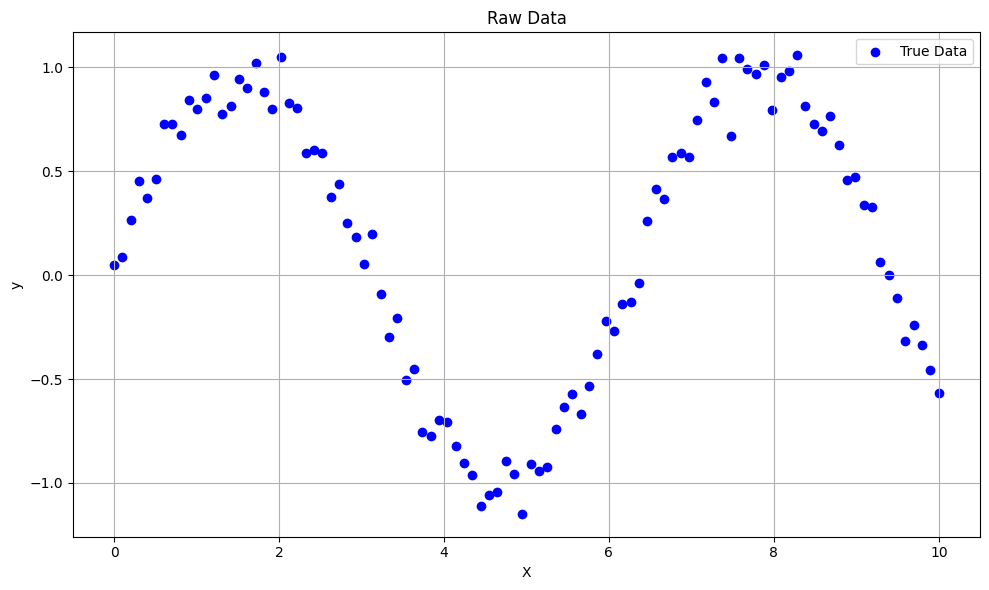

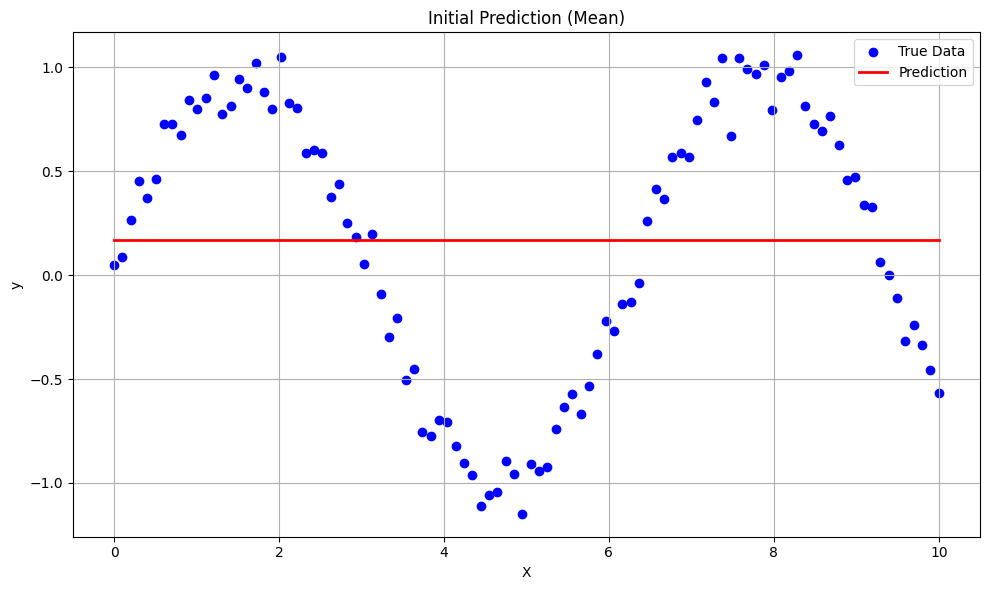

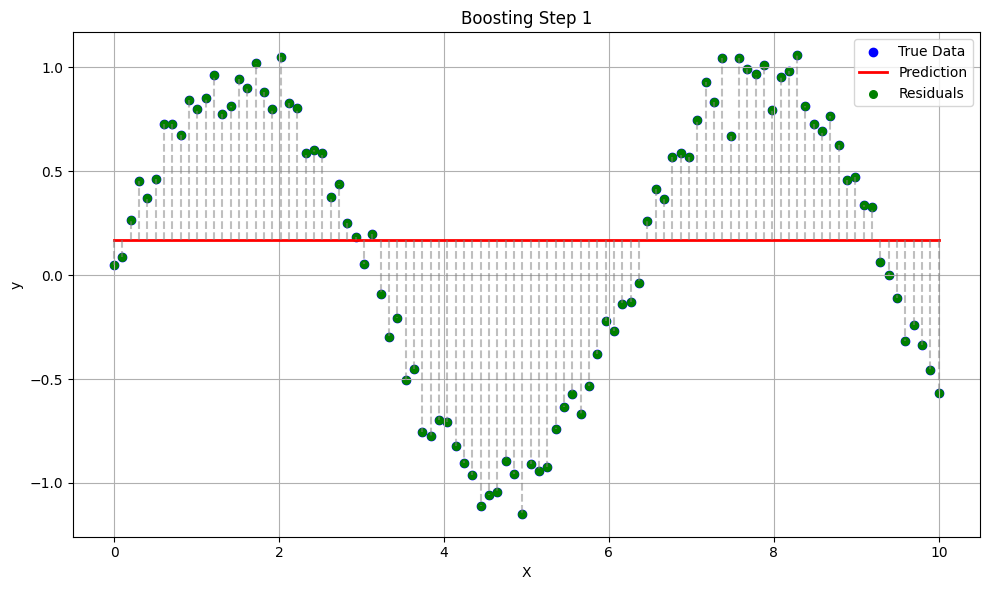

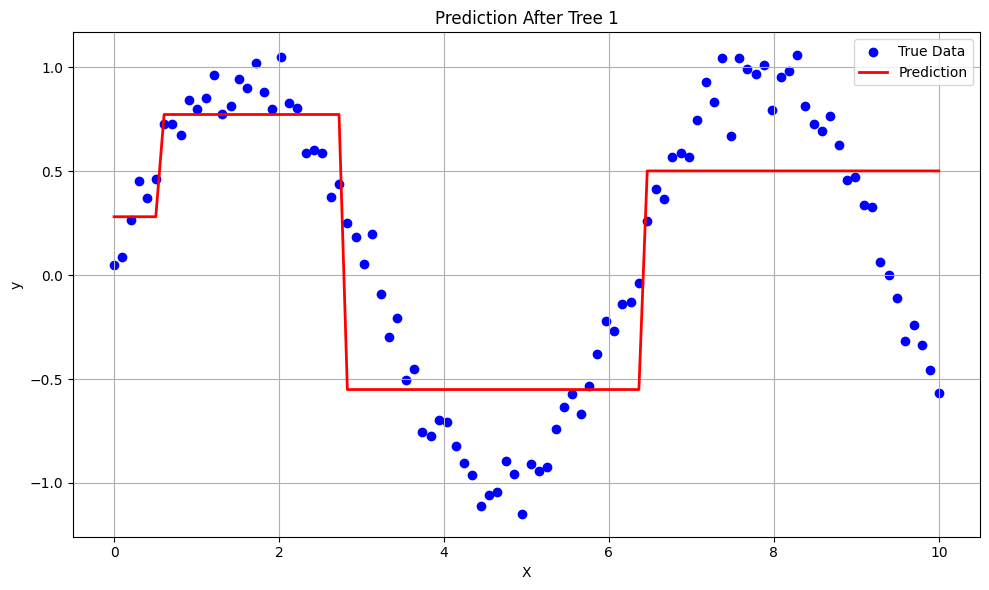

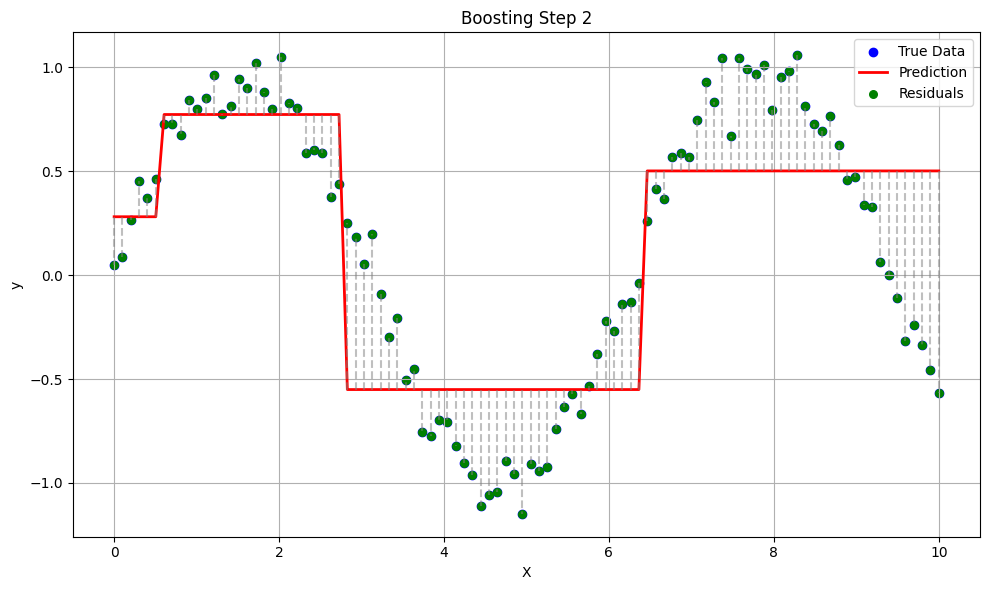

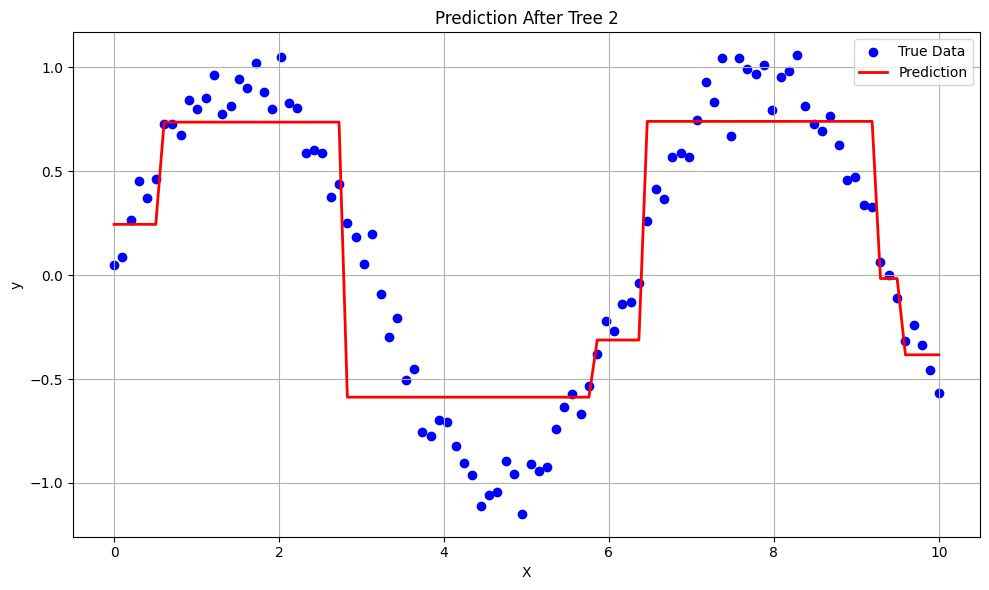

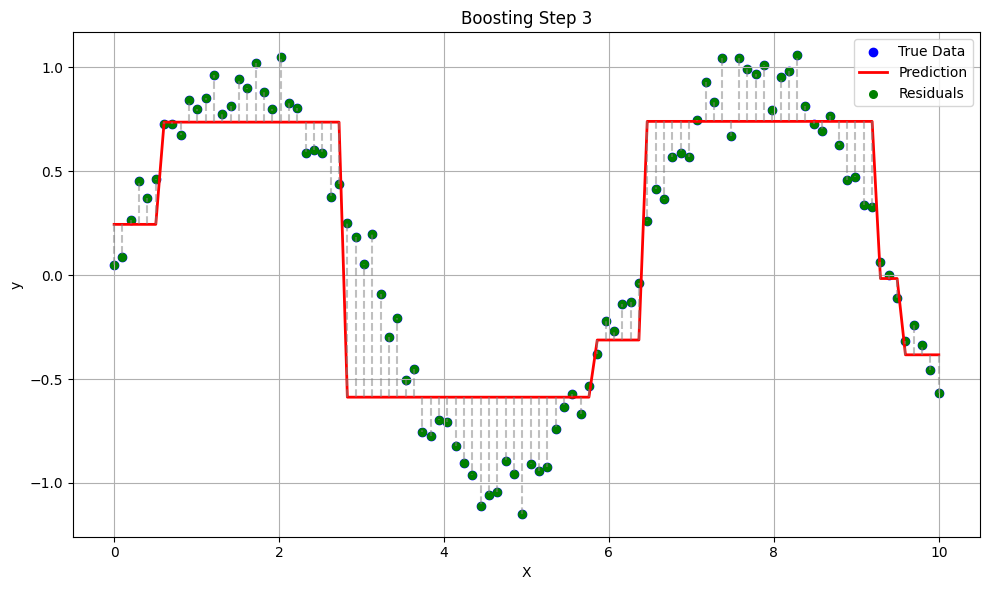

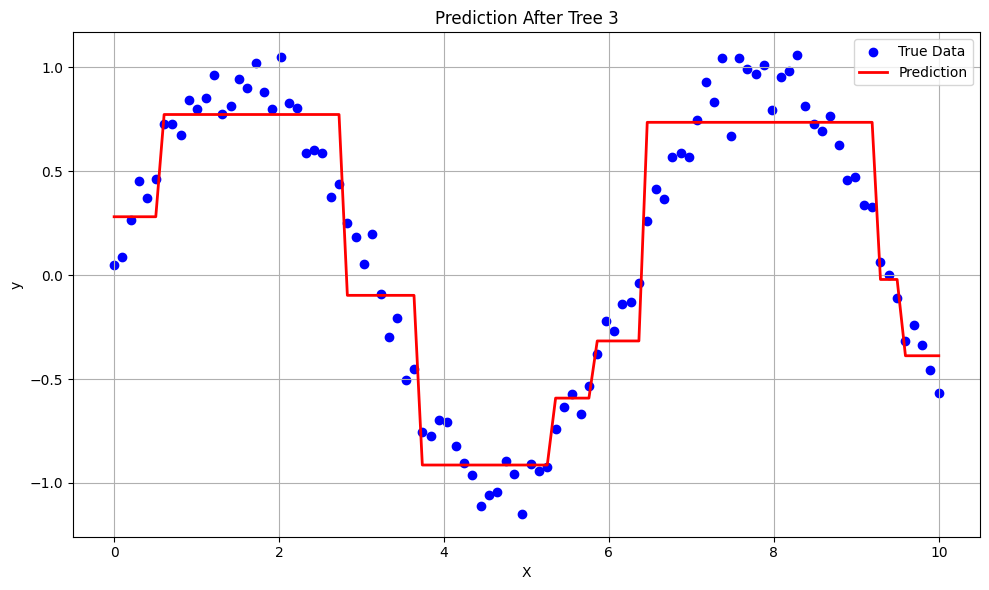

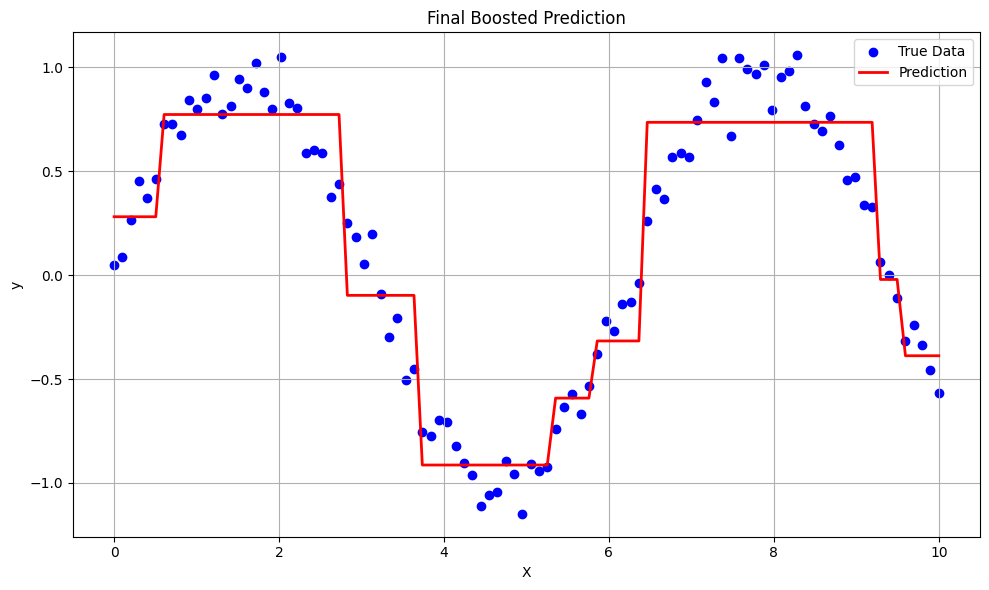

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# -----------------------------------------------------------------------------
# Step 1: Generate Synthetic Data
# -----------------------------------------------------------------------------
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).flatten() + np.random.normal(scale=0.1, size=X.flatten().shape)

# -----------------------------------------------------------------------------
# Step 2: Plot Helper Function
# -----------------------------------------------------------------------------
def plot_data(X, y, y_pred=None, residuals=None, title="", tree_idx=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label="True Data")

    if y_pred is not None:
        plt.plot(X, y_pred, color='red', label='Prediction', linewidth=2)

    if residuals is not None:
        for i in range(len(X)):
            plt.plot([X[i], X[i]], [y_pred[i], y[i]], color='gray', linestyle='--', alpha=0.5)

        plt.scatter(X, residuals + y_pred, color='green', s=30, label='Residuals')

    if tree_idx is not None:
        plt.title(f"Boosting Step {tree_idx+1}")
    else:
        plt.title(title)

    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# Step 3: Plot Raw Data
# -----------------------------------------------------------------------------
plot_data(X, y, title="Raw Data")

# -----------------------------------------------------------------------------
# Step 4: Initialize with Mean Prediction
# -----------------------------------------------------------------------------
y_pred = np.full_like(y, y.mean())
plot_data(X, y, y_pred, title="Initial Prediction (Mean)")

# -----------------------------------------------------------------------------
# Step 5: Iterative Boosting with Residual Visualization
# -----------------------------------------------------------------------------
n_trees = 3
max_depth = 2
learning_rate = 1.0
trees = []

for i in range(n_trees):
    residuals = y - y_pred

    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree.fit(X, residuals)
    update = tree.predict(X)

    # Store tree for potential reuse or inspection
    trees.append(tree)

    # Show residuals as green vertical arrows
    plot_data(X, y, y_pred, residuals=residuals, tree_idx=i)

    # Update prediction
    y_pred += learning_rate * update

    # Show updated prediction
    plot_data(X, y, y_pred, title=f"Prediction After Tree {i+1}")

# -----------------------------------------------------------------------------
# Final Overview
# -----------------------------------------------------------------------------
plot_data(X, y, y_pred, title="Final Boosted Prediction")


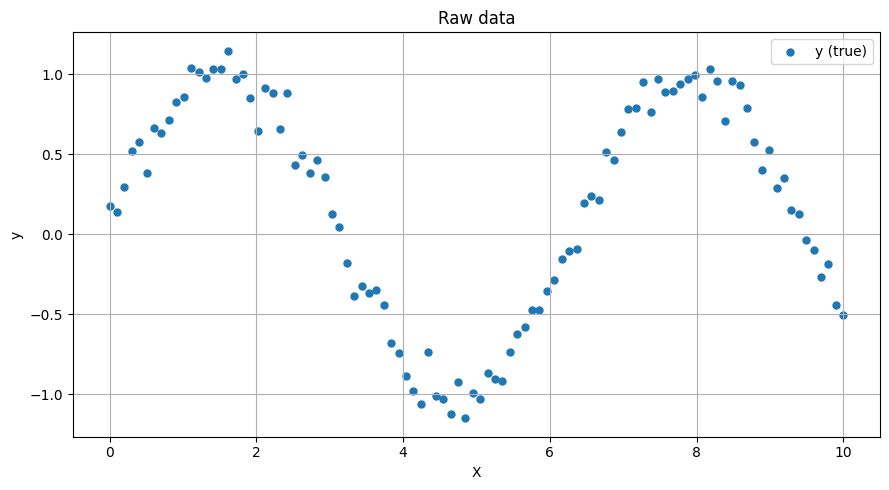

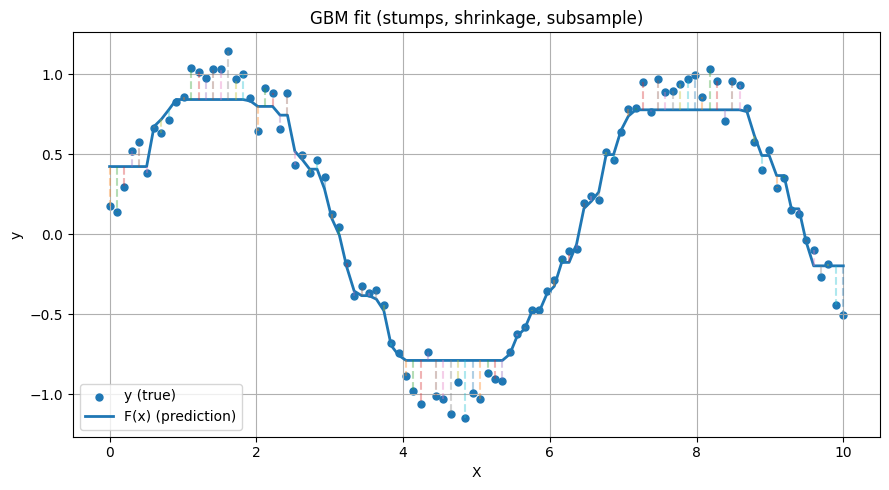

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

def fit_gbm(X, y, n_trees=200, learning_rate=0.1, max_depth=1,
            subsample=1.0, min_samples_leaf=5, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y)
    F = np.full(n, y.mean(), dtype=float)  # F0 = mean(y) for L2
    trees, weights, feats = [], [], []

    for m in range(n_trees):
        if subsample < 1.0:
            idx = rng.choice(n, size=int(subsample*n), replace=False)
        else:
            idx = np.arange(n)

        r = y[idx] - F[idx]  # negative gradient for L2
        tree = DecisionTreeRegressor(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf,
            random_state=random_state + m
        ).fit(X[idx], r)

        update = tree.predict(X)
        F += learning_rate * update

        trees.append(tree)
        weights.append(learning_rate)
    return {"init": y.mean(), "trees": trees, "weights": np.array(weights)}

def predict_gbm(model, X):
    F = np.full(X.shape[0], model["init"], dtype=float)
    for w, t in zip(model["weights"], model["trees"]):
        F += w * t.predict(X)
    return F

def plot_with_residuals(X, y, y_pred=None, title=""):
    plt.figure(figsize=(9,5))
    plt.scatter(X, y, label="y (true)", s=25)
    if y_pred is not None:
        plt.plot(X, y_pred, label="F(x) (prediction)", linewidth=2)
        # residual arrows from prediction to target
        for xi, yi, fi in zip(X.ravel(), y, y_pred):
            plt.plot([xi, xi], [fi, yi], linestyle='--', alpha=0.35)
    plt.title(title)
    plt.xlabel("X"); plt.ylabel("y"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# demo
np.random.seed(0)
X = np.linspace(0, 10, 100).reshape(-1,1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, size=X.shape[0])

model = fit_gbm(X, y, n_trees=200, learning_rate=0.1, max_depth=1, subsample=0.8)
y_pred = predict_gbm(model, X)
plot_with_residuals(X, y, title="Raw data")
plot_with_residuals(X, y, y_pred, title="GBM fit (stumps, shrinkage, subsample)")


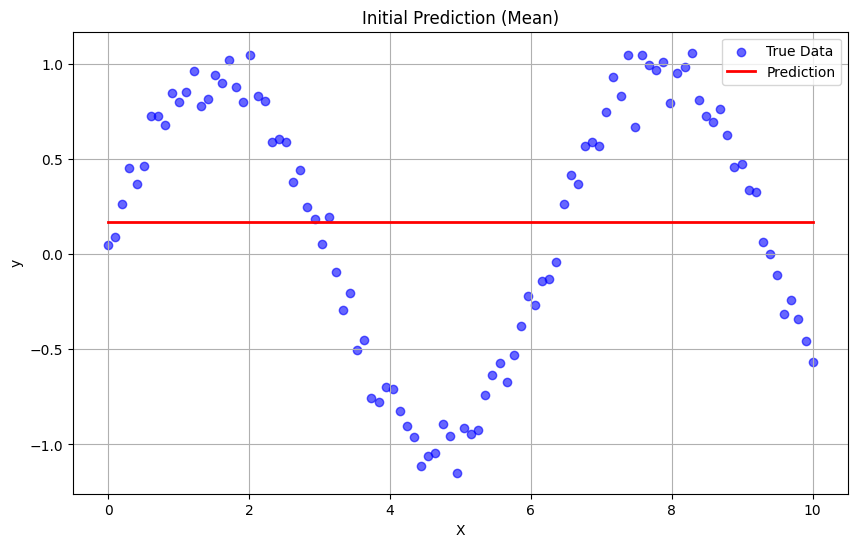

Initial MSE: 0.4499
After tree 1: MSE = 0.2547


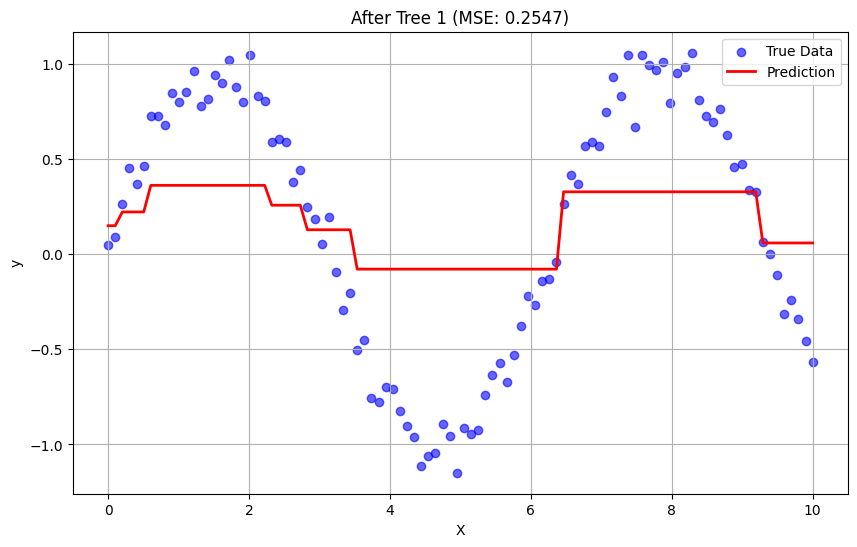

After tree 2: MSE = 0.1508


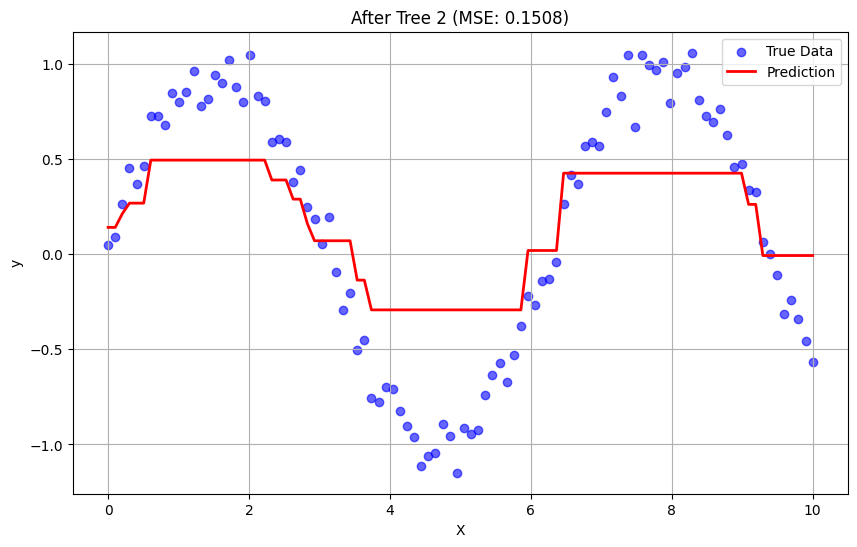

After tree 3: MSE = 0.0933


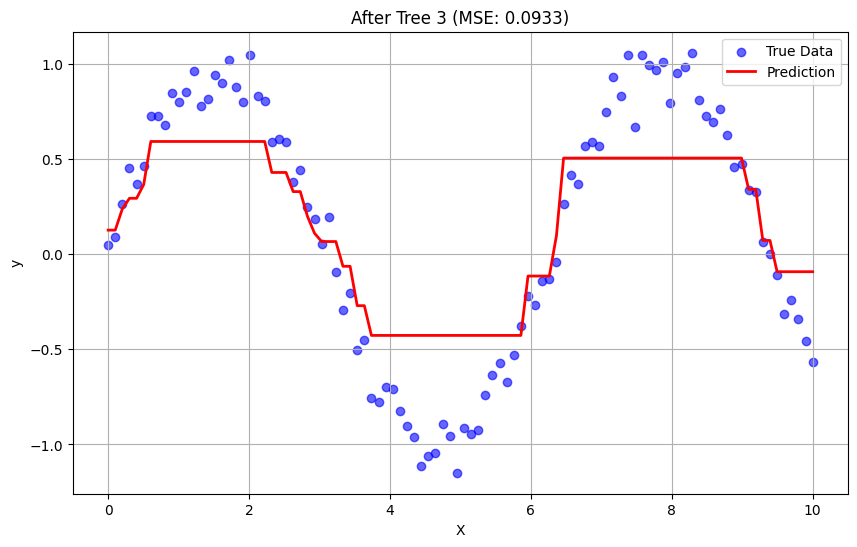

After tree 4: MSE = 0.0612


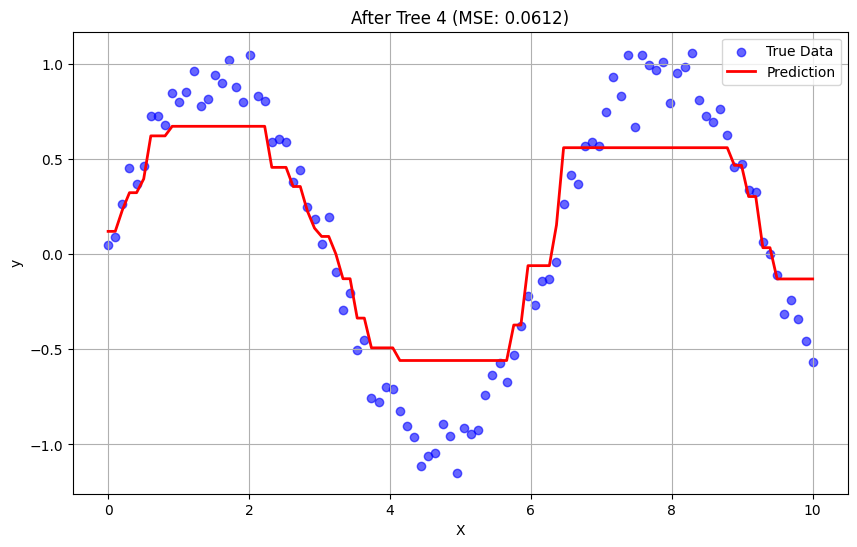

After tree 5: MSE = 0.0371


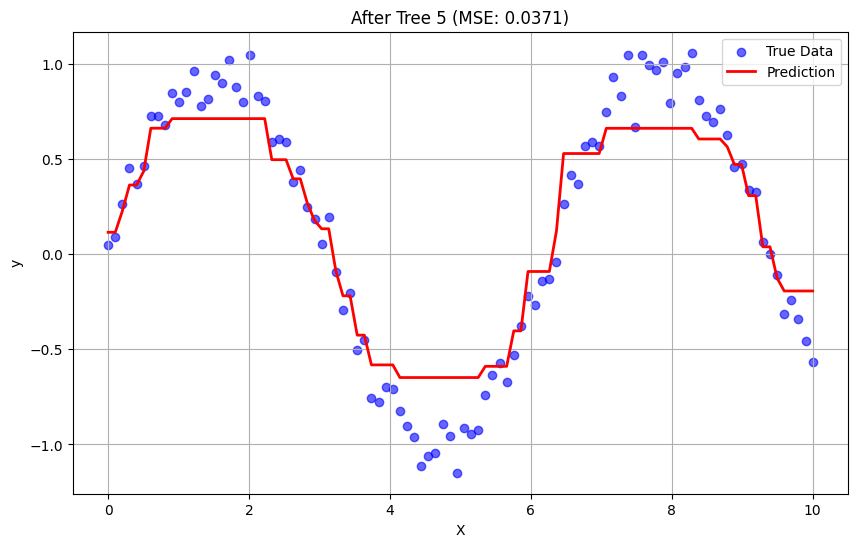


Final MSE: 0.0371


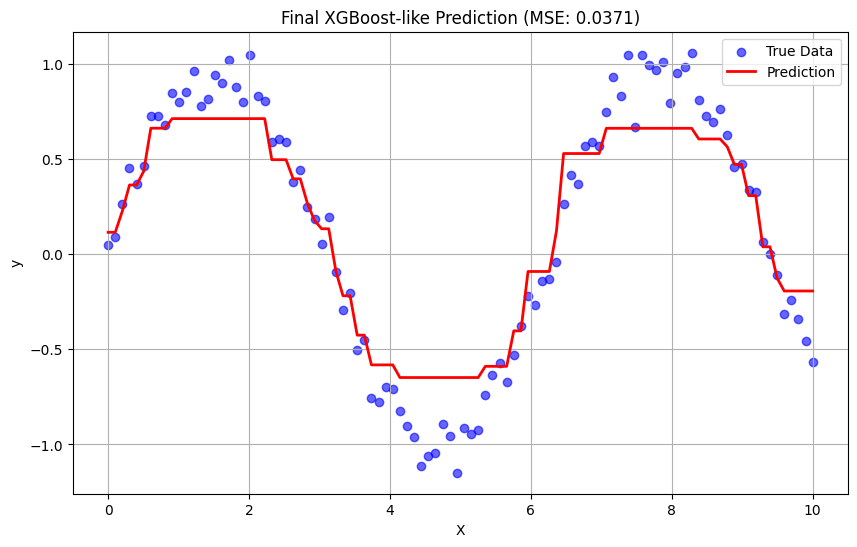


Comparison with standard gradient boosting:
Standard gradient boosting MSE: 0.0310
XGBoost-like MSE: 0.0371
Difference: 0.0061


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# -----------------------------------------------------------------------------
# Step 1: Data Generation
# -----------------------------------------------------------------------------
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).flatten() + np.random.normal(scale=0.1, size=100)

# -----------------------------------------------------------------------------
# Step 2: Plotting Function
# -----------------------------------------------------------------------------
def plot_prediction(X, y, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, label='True Data', color='blue', alpha=0.6)
    plt.plot(X, y_pred, label='Prediction', color='red', linewidth=2)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------------------------------------------------------
# Step 3: Fixed XGBoost-like Gradient Boosting
# -----------------------------------------------------------------------------
n_trees = 5
max_depth = 3
learning_rate = 0.3
lambda_reg = 1.0  # L2 regularization parameter

# Initialize predictions with mean
y_pred = np.full_like(y, fill_value=y.mean())
plot_prediction(X, y, y_pred, "Initial Prediction (Mean)")

print(f"Initial MSE: {np.mean((y - y_pred)**2):.4f}")

for t in range(n_trees):
    # Compute gradients and Hessians for squared loss: L = 0.5 * (y_true - y_pred)^2
    grad = y_pred - y      # First derivative: ∂L/∂y_pred = y_pred - y_true
    hess = np.ones_like(y) # Second derivative: ∂²L/∂y_pred² = 1 (constant for squared loss)
    
    # Fit tree to the negative gradients (i.e., the residuals)
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42+t)
    tree.fit(X, -grad)  # Negative gradient points toward the minimum
    
    # Get leaf assignments for all samples
    leaf_indices = tree.apply(X)
    unique_leaves = np.unique(leaf_indices)
    
    # Calculate optimal leaf weights using XGBoost formula
    update = np.zeros_like(y)
    
    for leaf in unique_leaves:
        # Find all samples in this leaf
        leaf_mask = (leaf_indices == leaf)
        
        # Sum gradients and hessians for samples in this leaf
        G_j = np.sum(grad[leaf_mask])  # Sum of gradients in leaf j
        H_j = np.sum(hess[leaf_mask])  # Sum of hessians in leaf j
        
        # Optimal leaf weight: w_j = -G_j / (H_j + λ)
        w_j = -G_j / (H_j + lambda_reg)
        
        # Assign this weight to all samples in the leaf
        update[leaf_mask] = w_j
    
    # Update predictions with learning rate
    y_pred += learning_rate * update
    
    # Show progress
    mse = np.mean((y - y_pred)**2)
    print(f"After tree {t+1}: MSE = {mse:.4f}")
    
    # Plot after each tree
    plot_prediction(X, y, y_pred, f"After Tree {t+1} (MSE: {mse:.4f})")

# -----------------------------------------------------------------------------
# Final Results
# -----------------------------------------------------------------------------
final_mse = np.mean((y - y_pred)**2)
print(f"\nFinal MSE: {final_mse:.4f}")
plot_prediction(X, y, y_pred, f"Final XGBoost-like Prediction (MSE: {final_mse:.4f})")

# -----------------------------------------------------------------------------
# Comparison with Standard Gradient Boosting (for reference)
# -----------------------------------------------------------------------------
print("\n" + "="*50)
print("Comparison with standard gradient boosting:")

# Reset for comparison
y_pred_standard = np.full_like(y, fill_value=y.mean())

for t in range(n_trees):
    # Standard approach: fit tree to residuals and use predictions directly
    residuals = y - y_pred_standard
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42+t)
    tree.fit(X, residuals)
    
    # Use tree predictions directly (no XGBoost leaf weight calculation)
    update = tree.predict(X)
    y_pred_standard += learning_rate * update

standard_mse = np.mean((y - y_pred_standard)**2)
print(f"Standard gradient boosting MSE: {standard_mse:.4f}")
print(f"XGBoost-like MSE: {final_mse:.4f}")
print(f"Difference: {abs(standard_mse - final_mse):.4f}")

🚀 BOOSTING ALGORITHMS TUTORIAL
📊 Generated synthetic datasets:
   - Regression: 100 samples, sine wave with noise
   - Classification: 200 samples, 2D binary problem

1️⃣  GRADIENT BOOSTING FOR REGRESSION

🎯 CONCEPT: Sequentially fit weak learners to residuals
   • Start with simple prediction (mean)
   • At each step, fit a tree to predict the residuals
   • Add the new prediction to ensemble
   • Repeat until convergence or max iterations



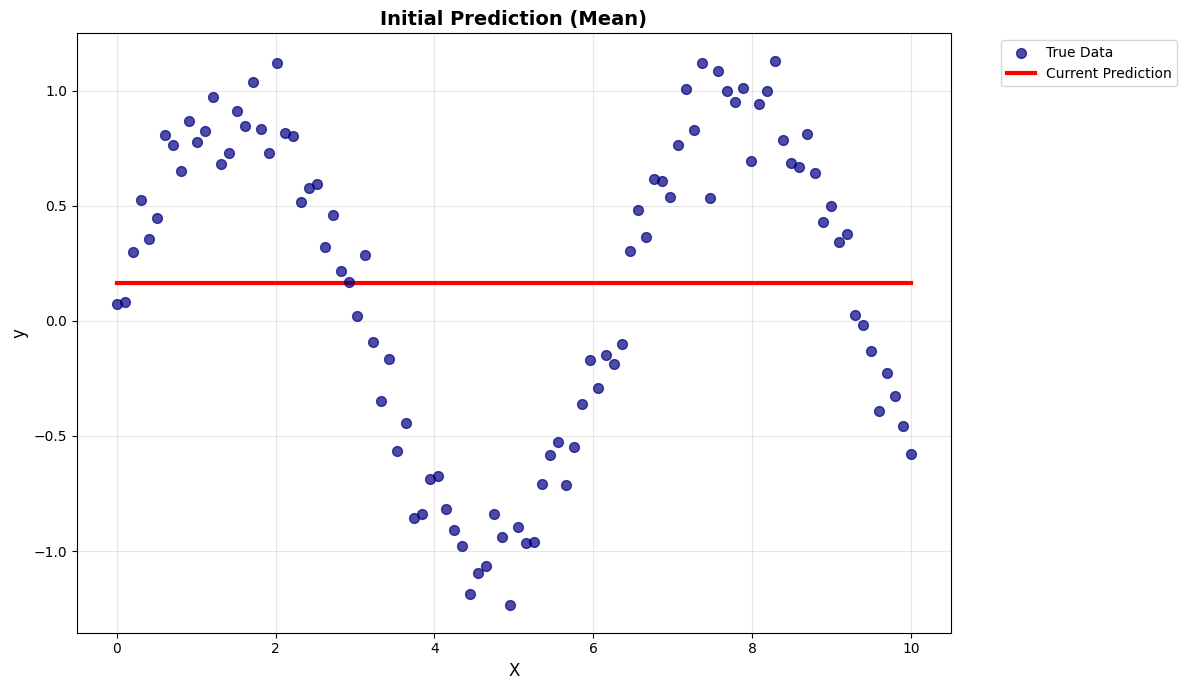

Parameters: n_trees=5, max_depth=3, learning_rate=0.8

Step 1:
  Residual MSE: 0.4600
  Residual MAE: 0.5970


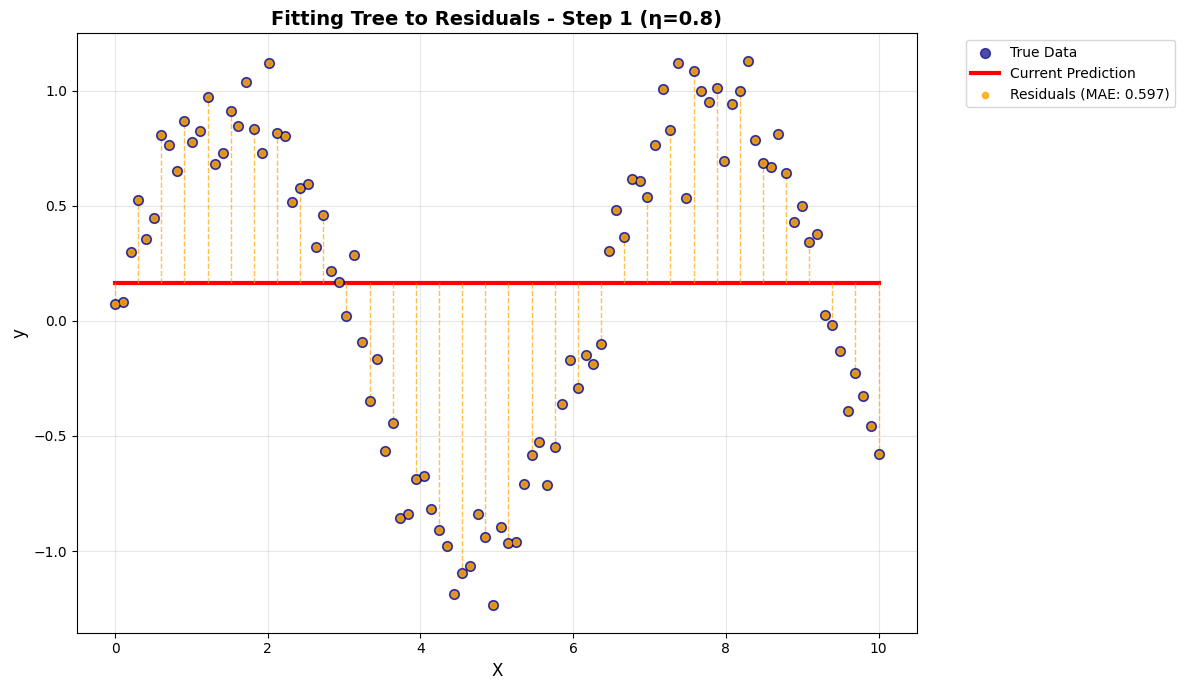

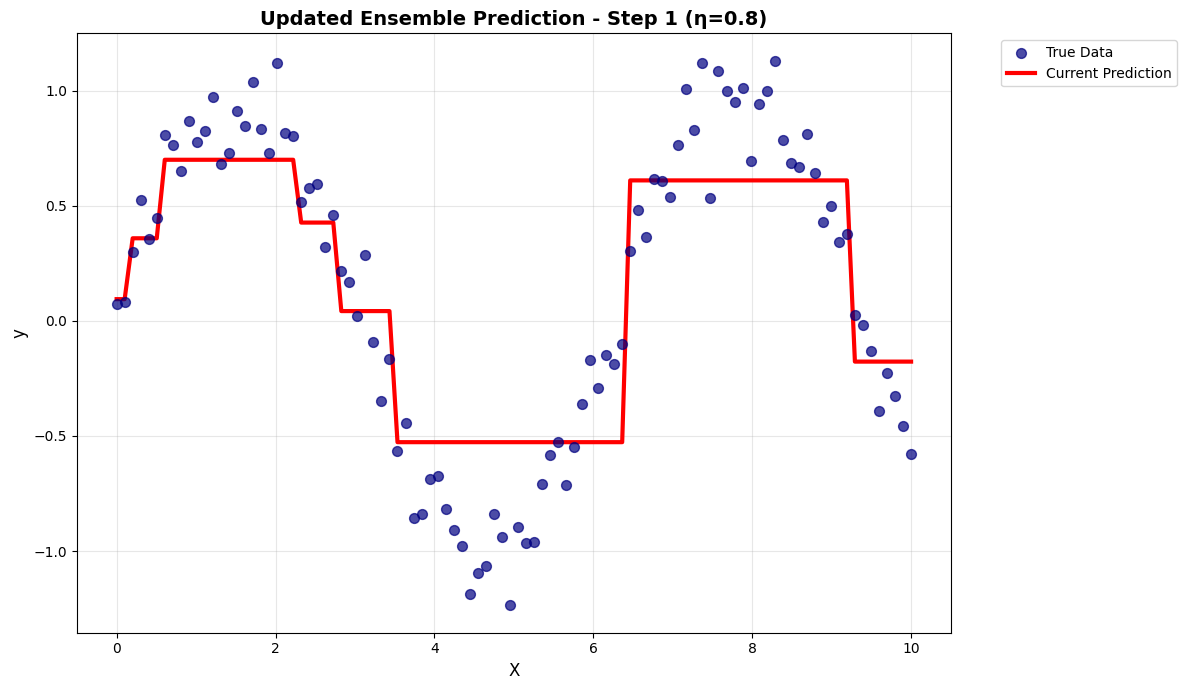


Step 2:
  Residual MSE: 0.0722
  Residual MAE: 0.2148


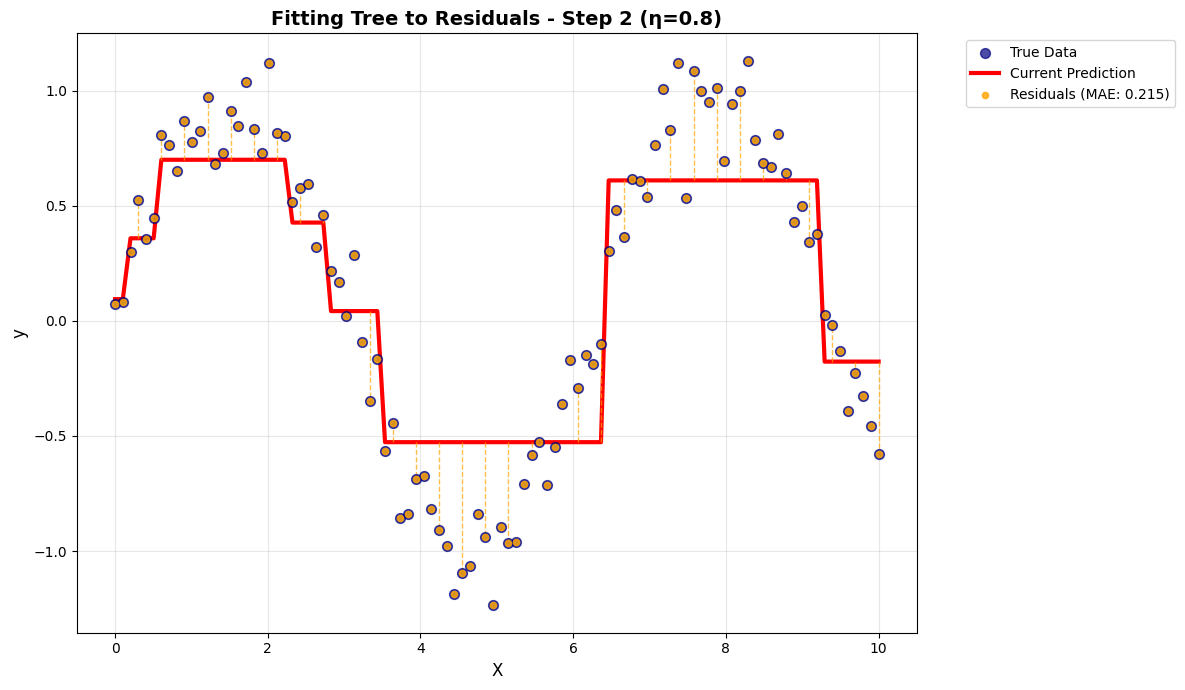

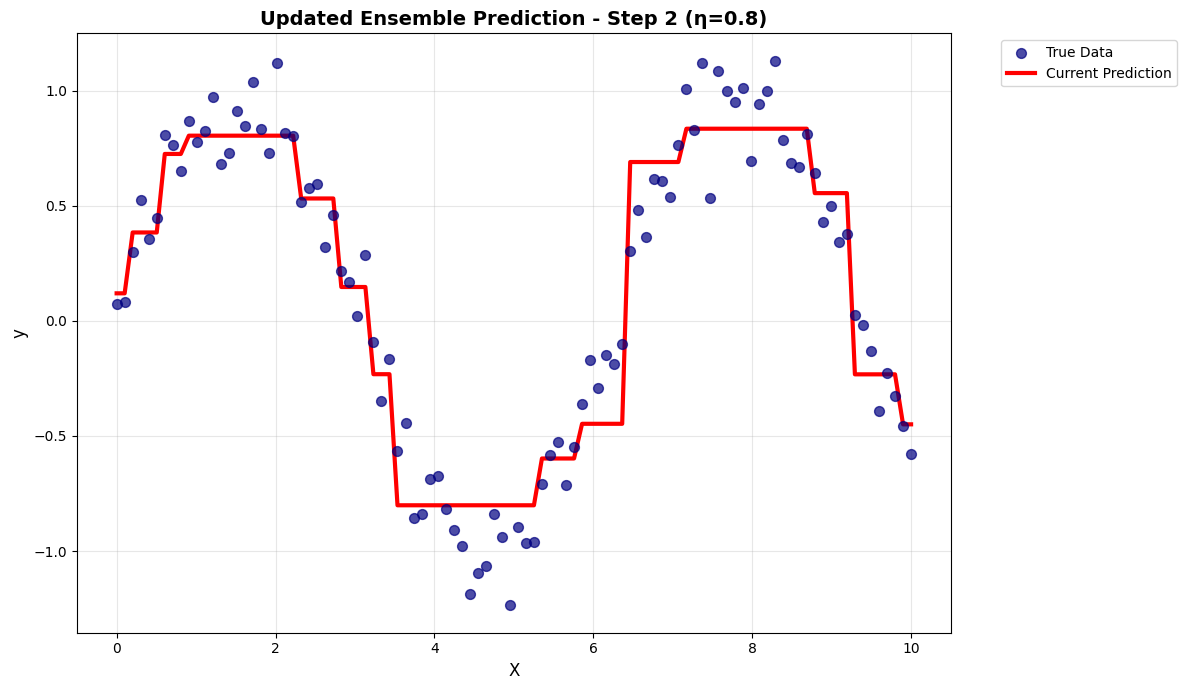


Step 3:
  Residual MSE: 0.0282
  Residual MAE: 0.1348


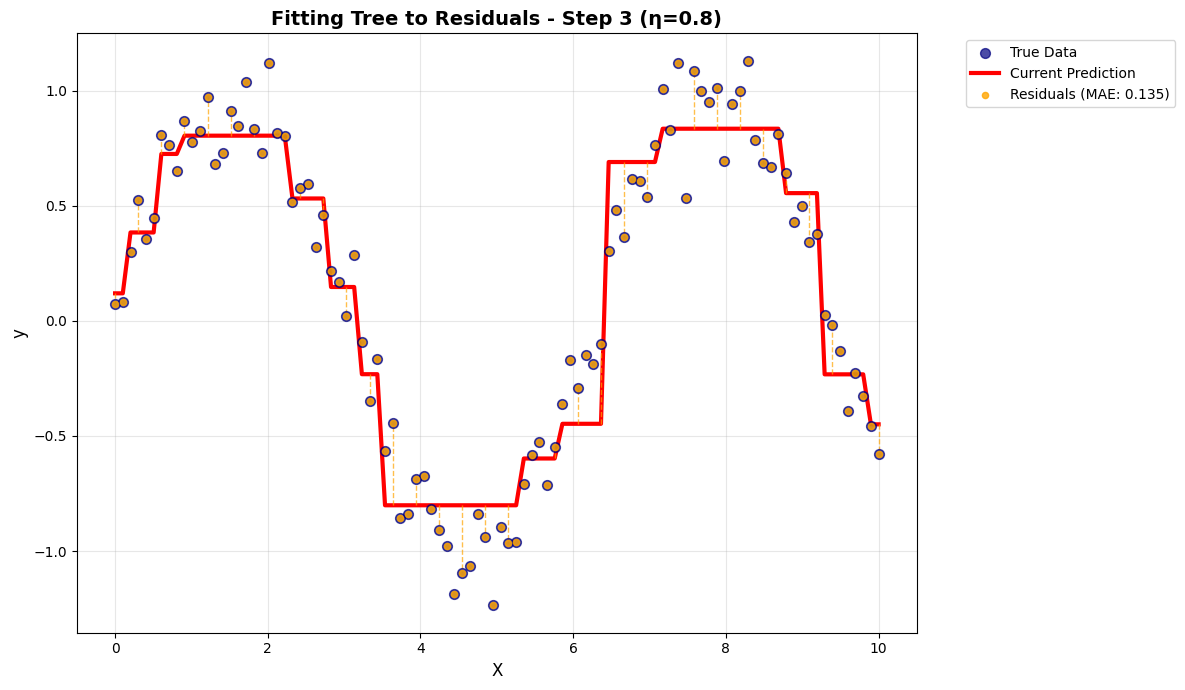

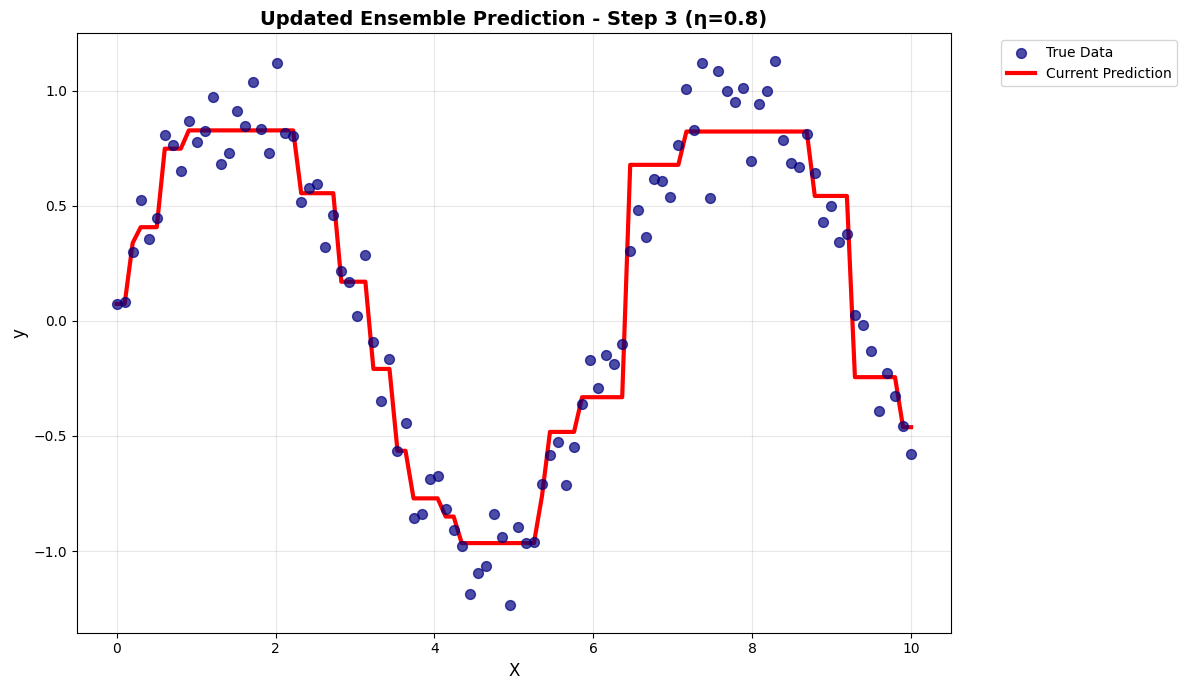


Step 4:
  Residual MSE: 0.0195
  Residual MAE: 0.1097


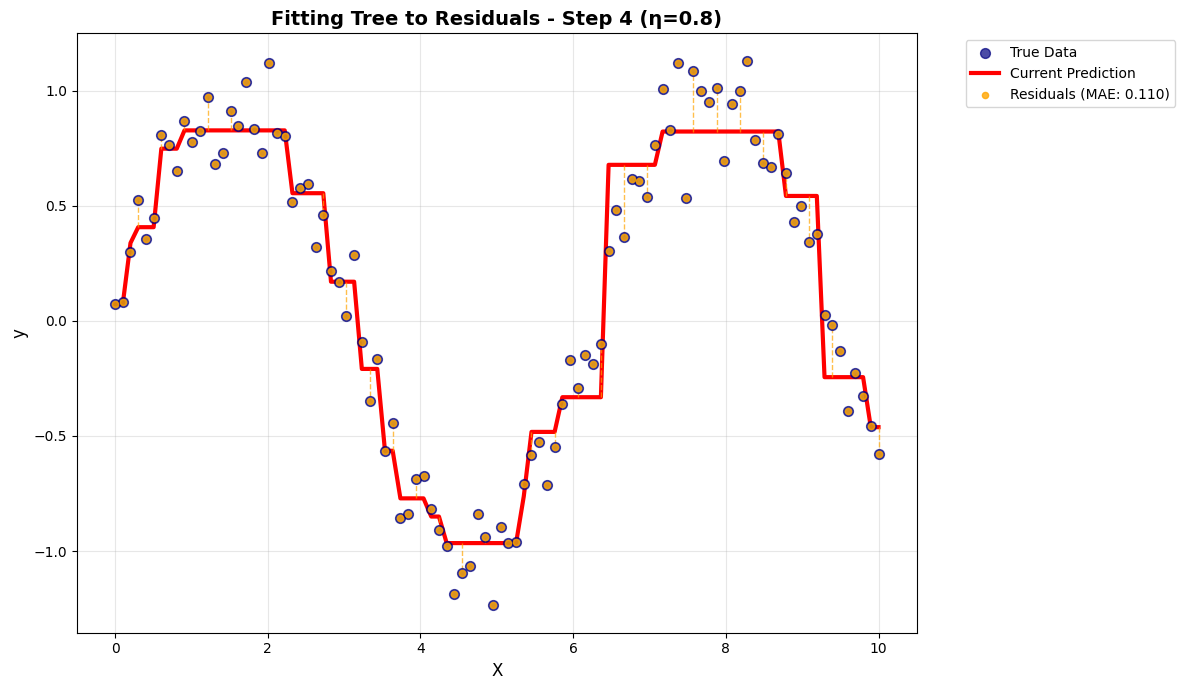

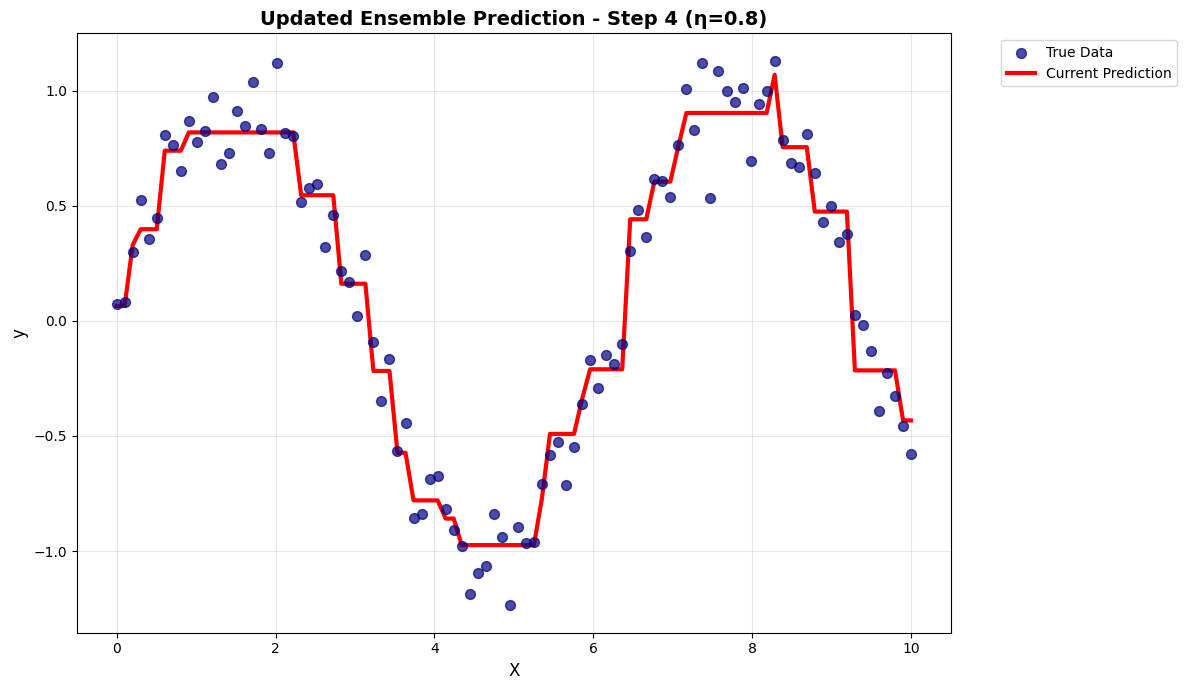


Step 5:
  Residual MSE: 0.0128
  Residual MAE: 0.0874


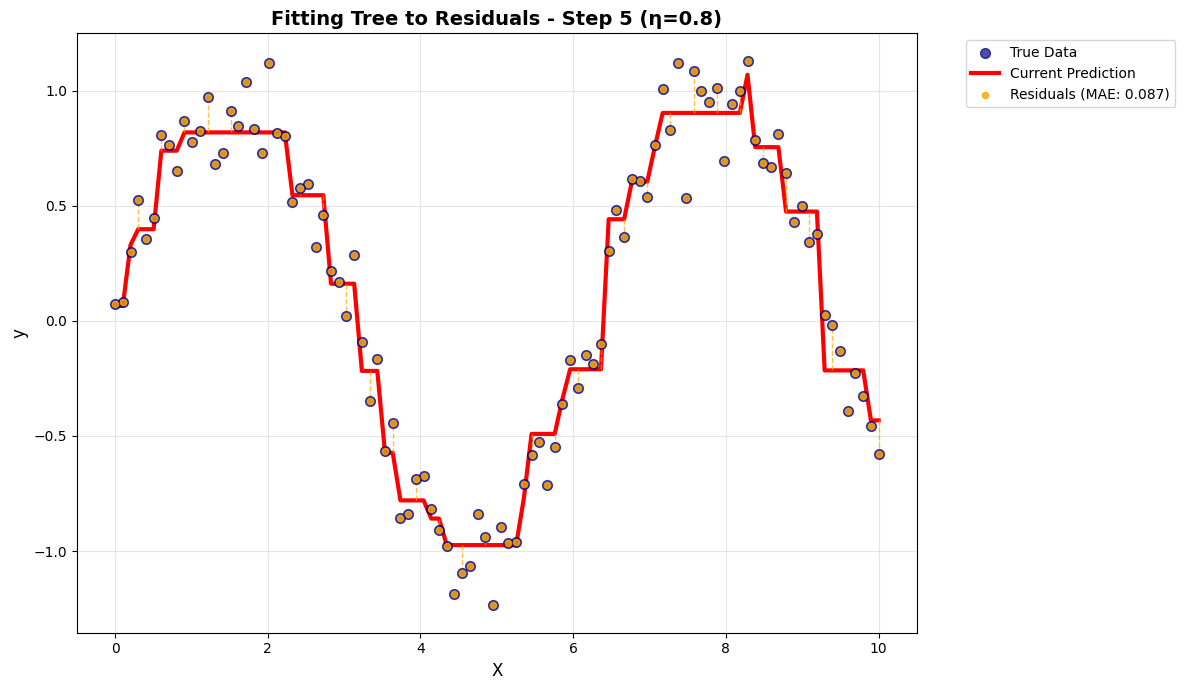

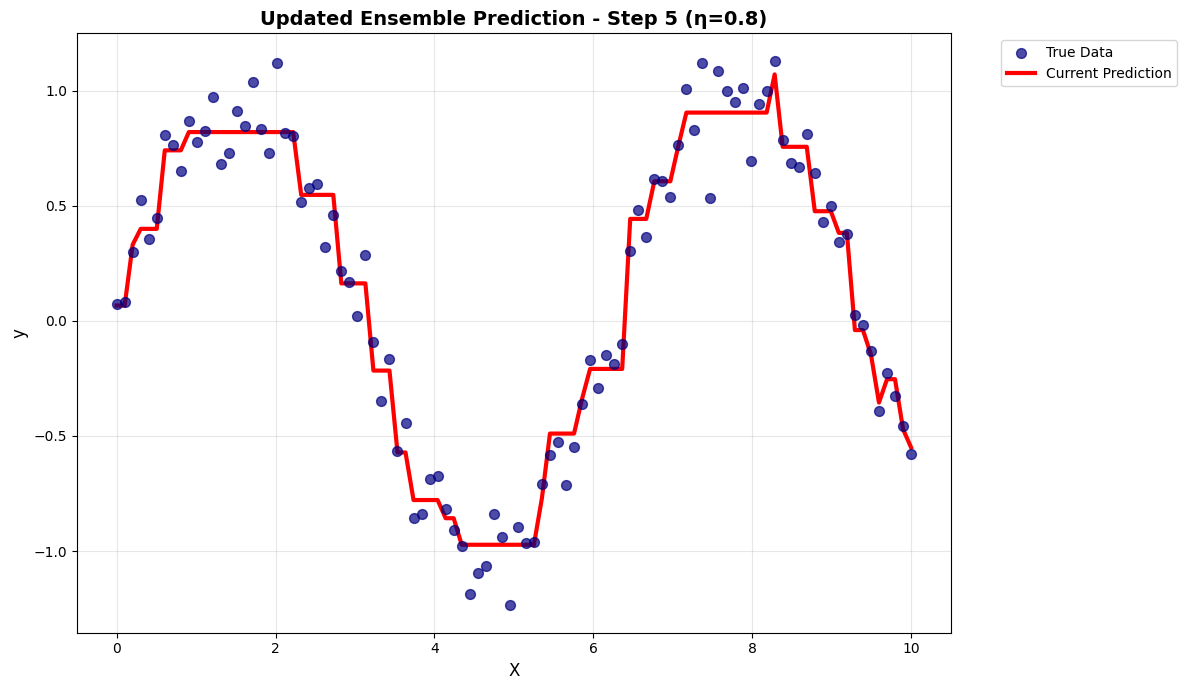

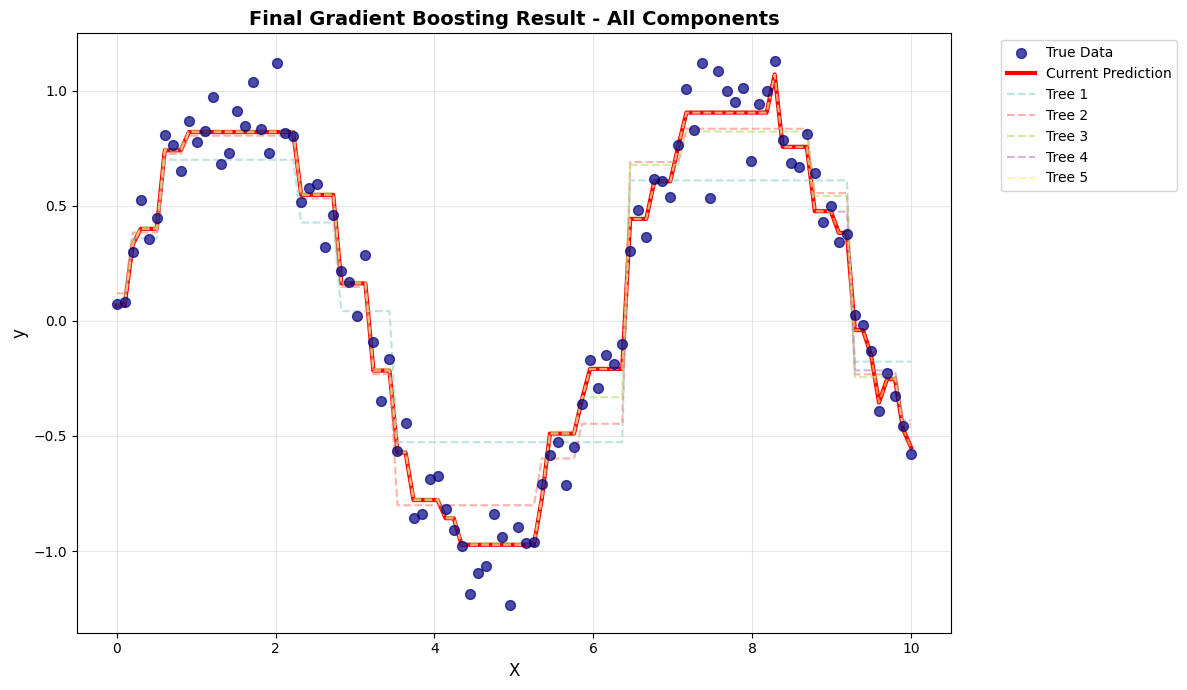


🎯 Final MSE: 0.0110

2️⃣  ADABOOST FOR CLASSIFICATION

🎯 CONCEPT: Adaptive Boosting - focus on misclassified examples
   • Start with equal weights for all samples
   • Train weak classifier on weighted data
   • Increase weights of misclassified examples  
   • Train next classifier on reweighted data
   • Combine classifiers with weighted voting

AdaBoost step-by-step demonstration:


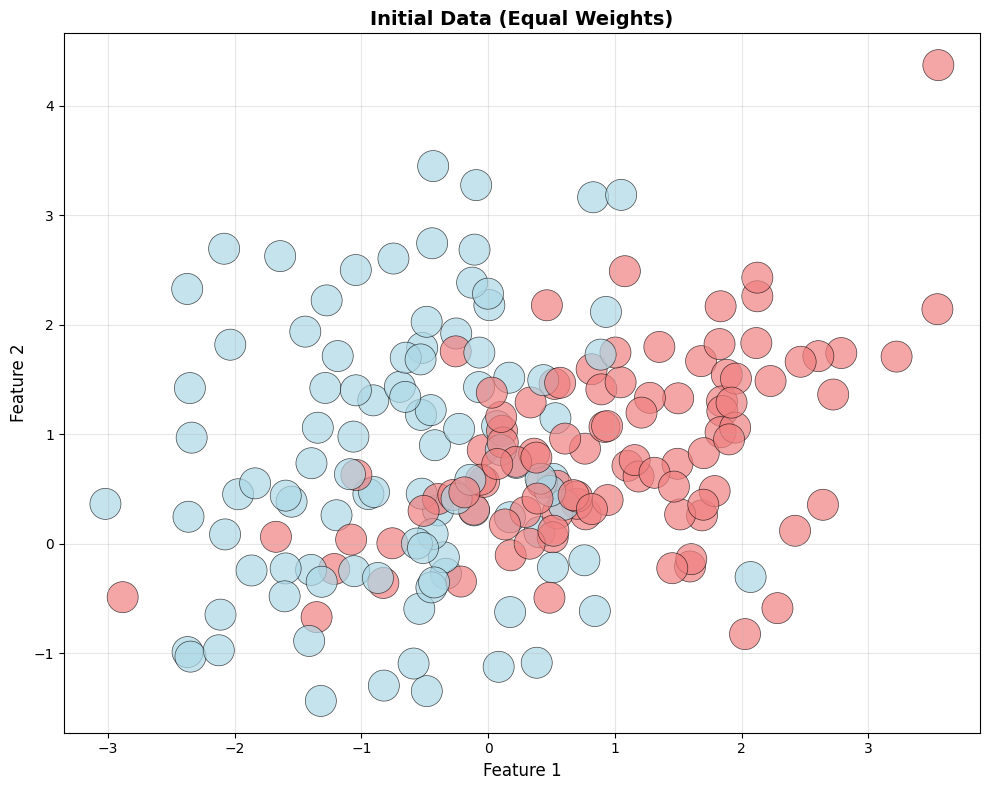


--- AdaBoost Step 1 ---
Weighted error: 0.2000
Classifier weight (α): 0.6931


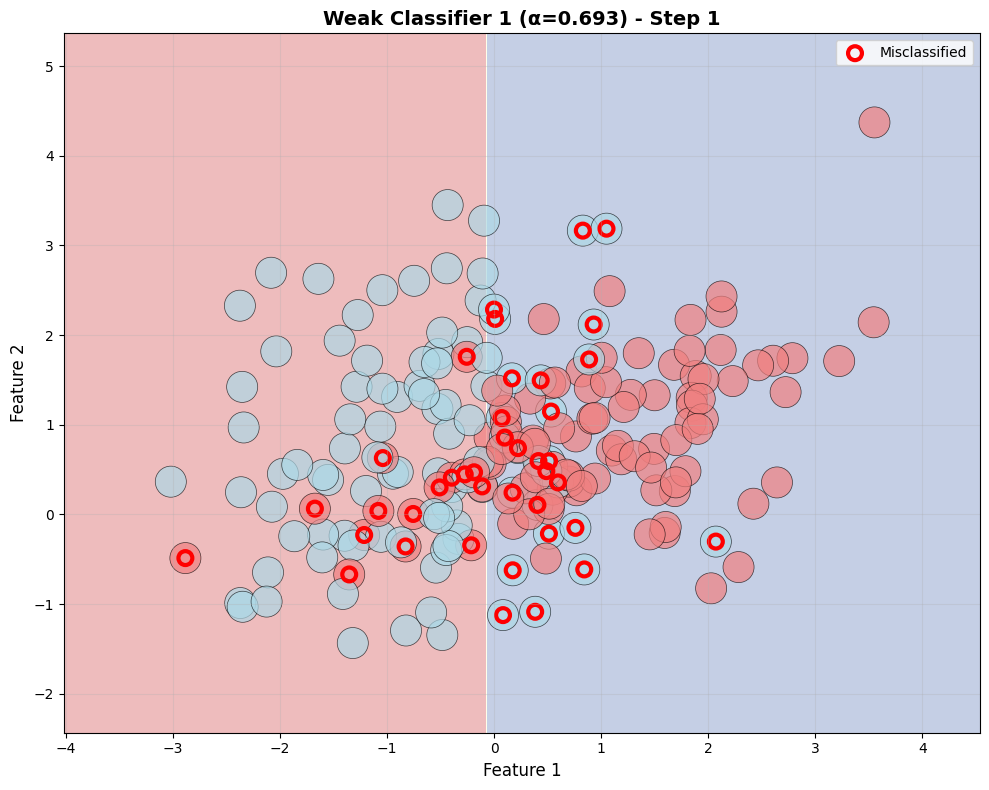

Weight concentration: 4.00x
Misclassified samples: 40/200

--- AdaBoost Step 2 ---
Weighted error: 0.2184
Classifier weight (α): 0.6375


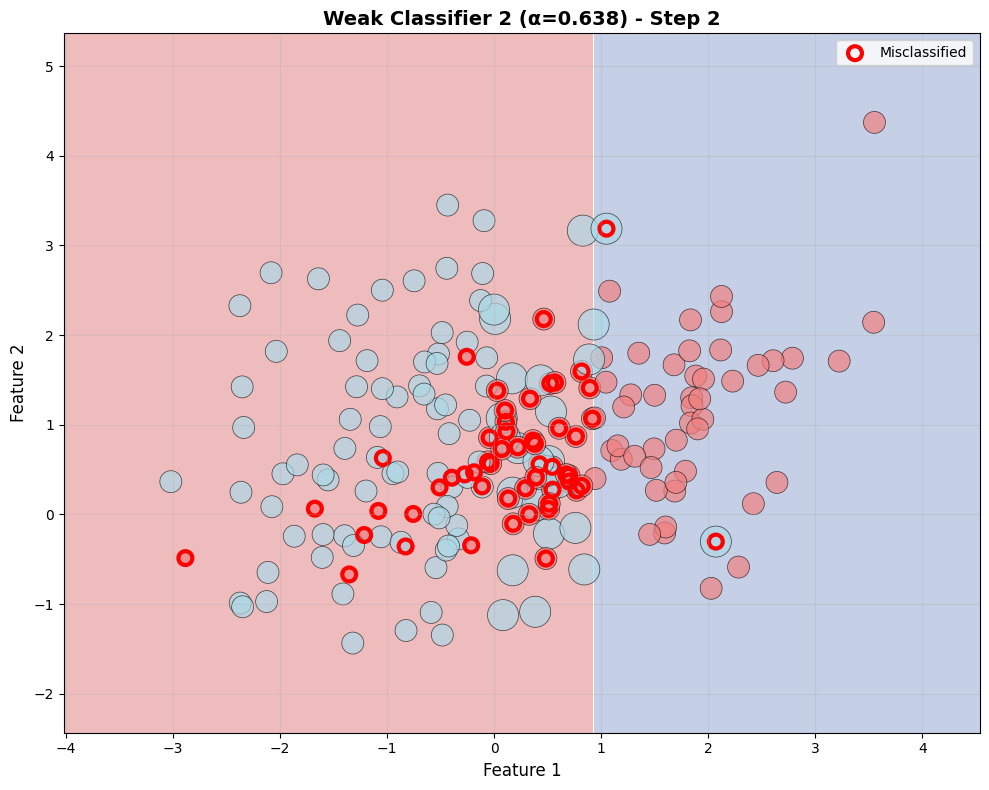

Weight concentration: 14.32x
Misclassified samples: 53/200

--- AdaBoost Step 3 ---
Weighted error: 0.1535
Classifier weight (α): 0.8539


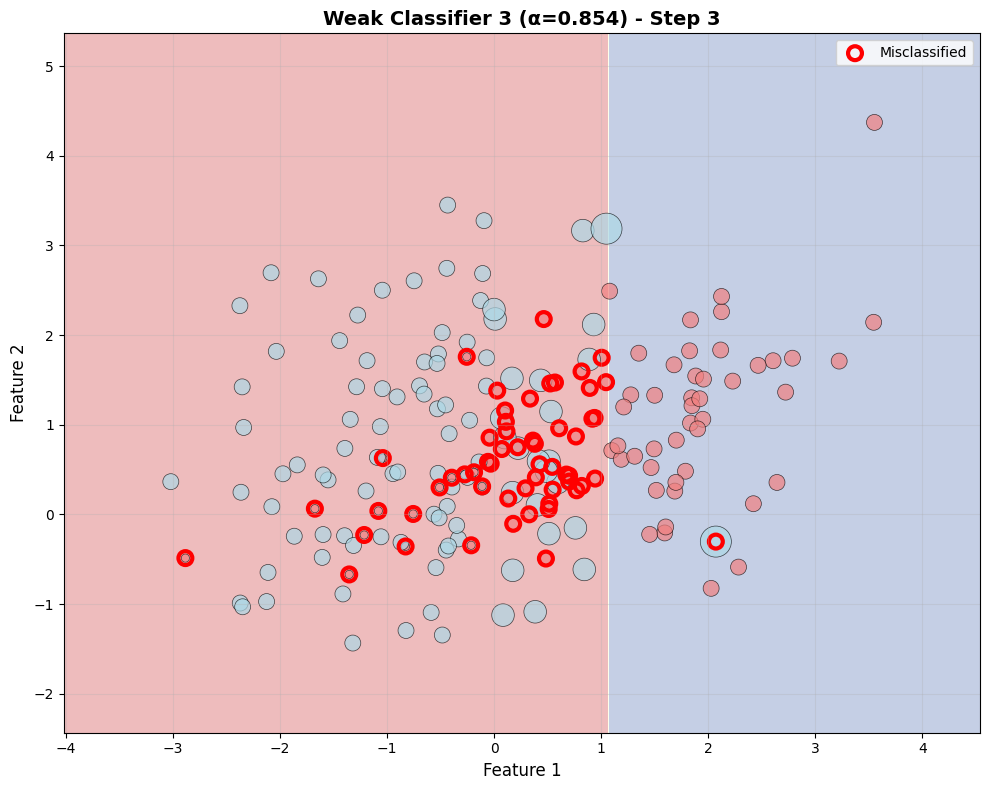

Weight concentration: 78.97x
Misclassified samples: 56/200

--- AdaBoost Step 4 ---
Weighted error: 0.1072
Classifier weight (α): 1.0600


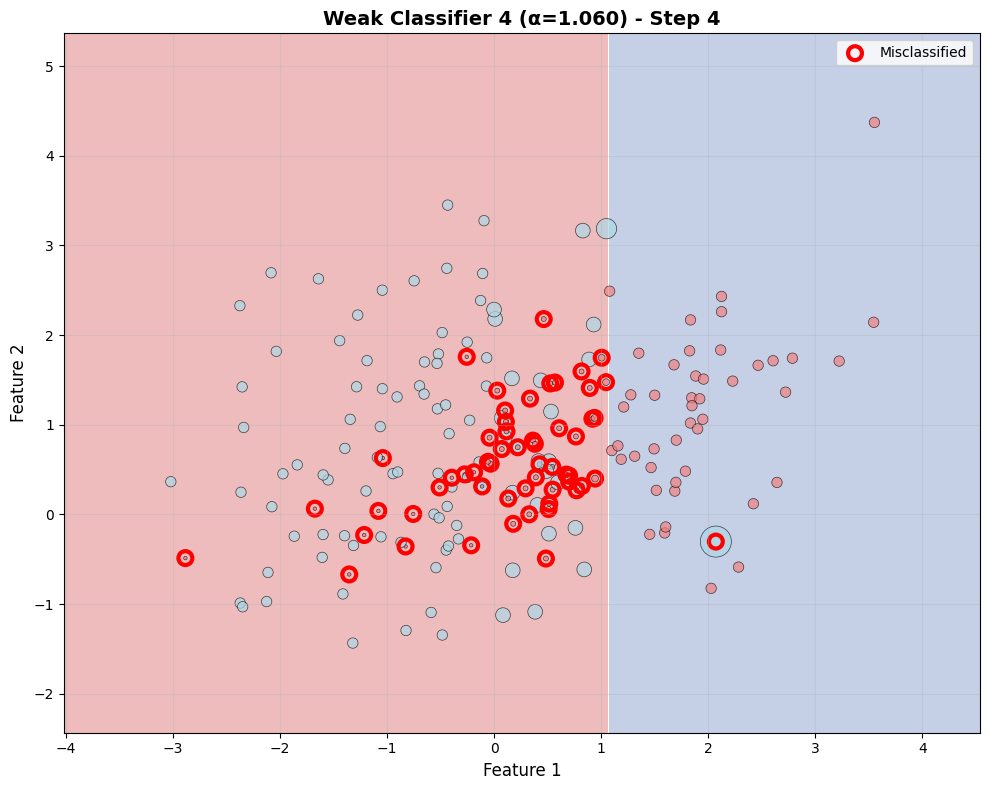

Weight concentration: 657.93x
Misclassified samples: 56/200


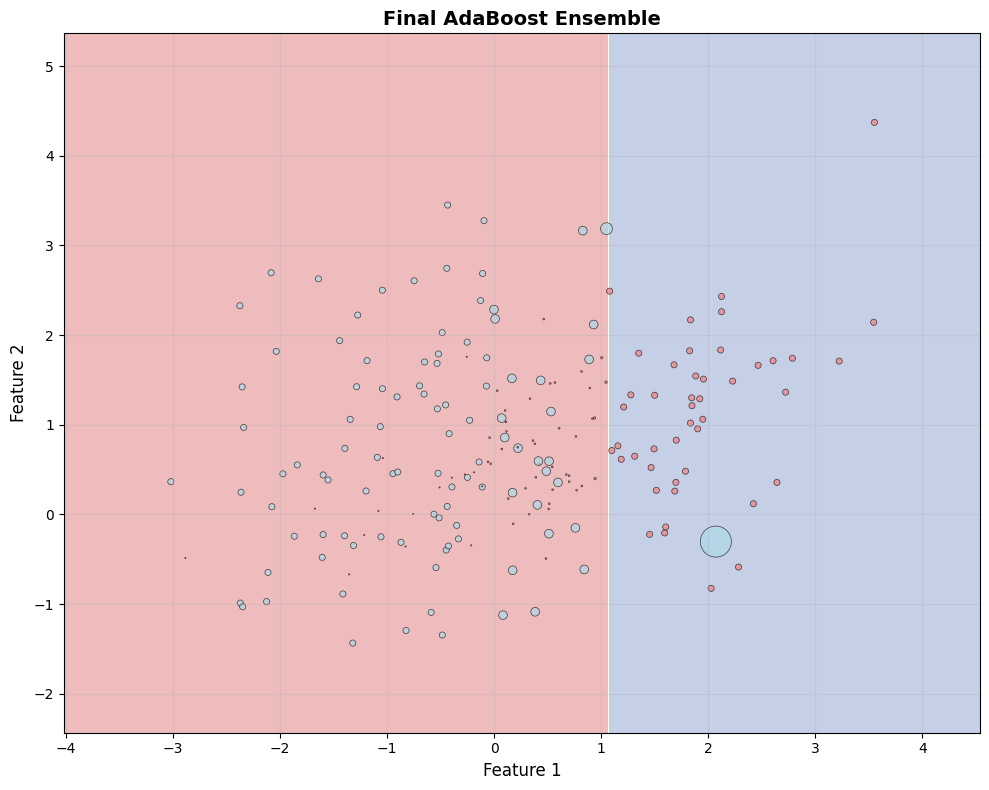


🎯 Results:
Manual AdaBoost accuracy: 0.720
Sklearn AdaBoost accuracy: 0.815

3️⃣  XGBOOST-STYLE REGULARIZED GRADIENT BOOSTING

🎯 CONCEPT: Gradient Boosting + Regularization + Advanced Optimization
   • Use second-order gradients (Hessian) for better optimization
   • Add L1/L2 regularization to prevent overfitting
   • Advanced tree construction algorithms
   • Built-in cross-validation and early stopping

XGBoost-style parameters:
  learning_rate: 0.1
  reg_lambda (L2): 1.0
  max_depth: 3
  n_estimators: 8


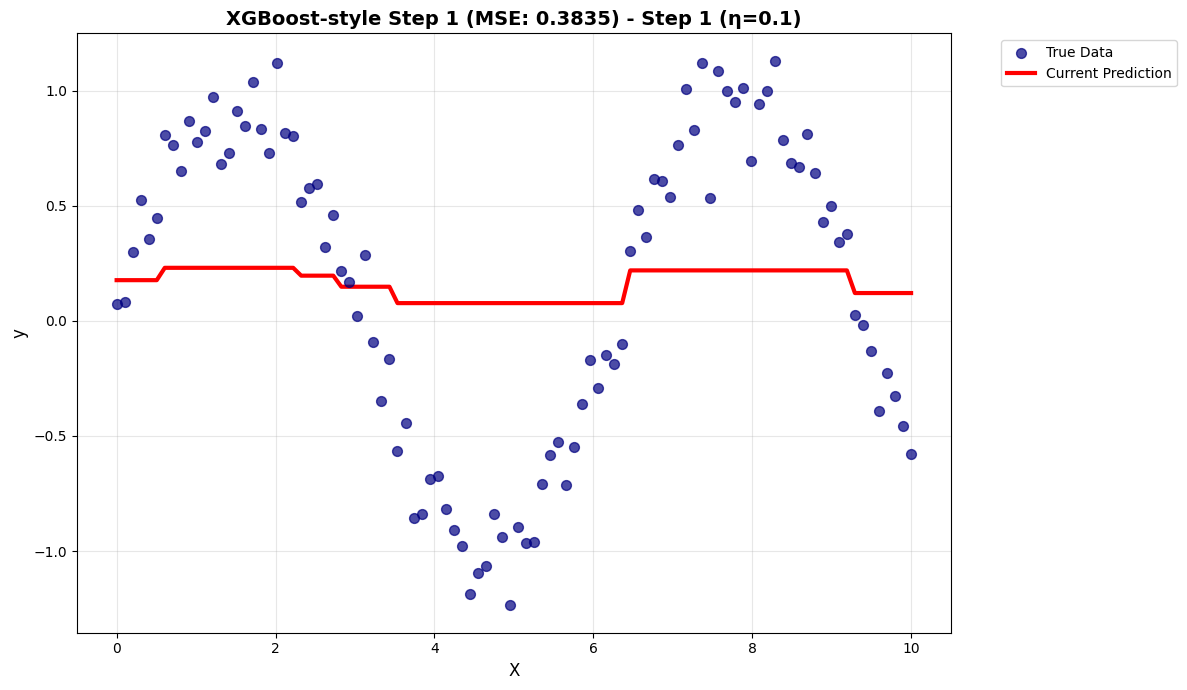

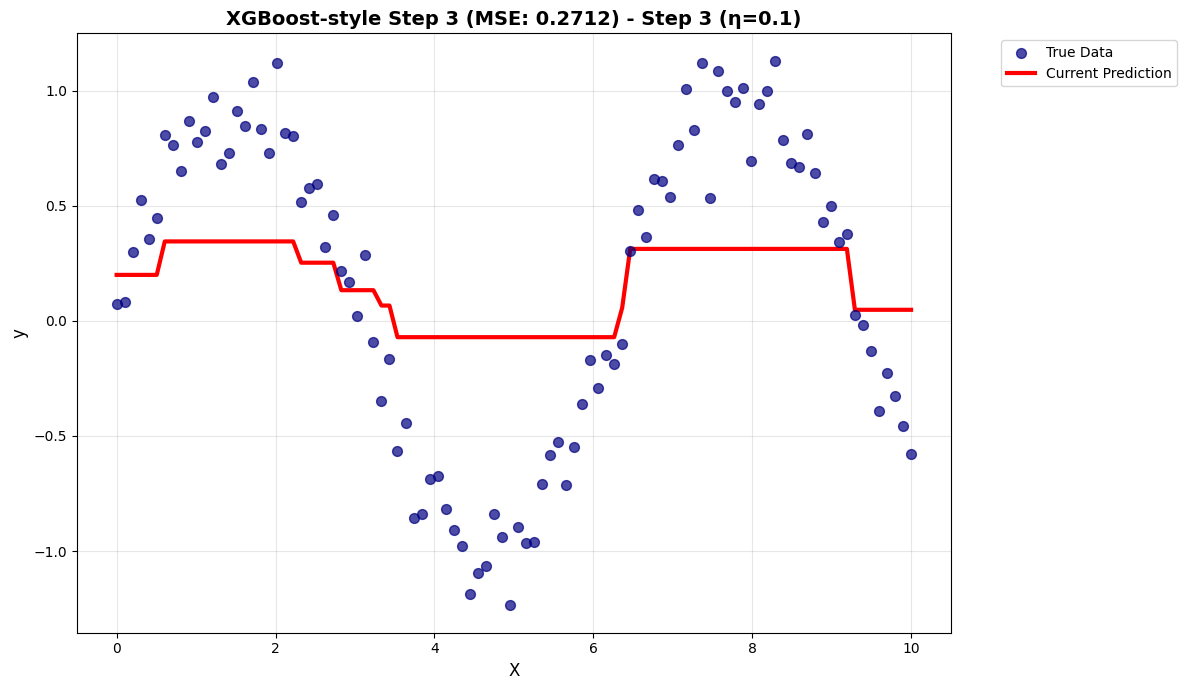

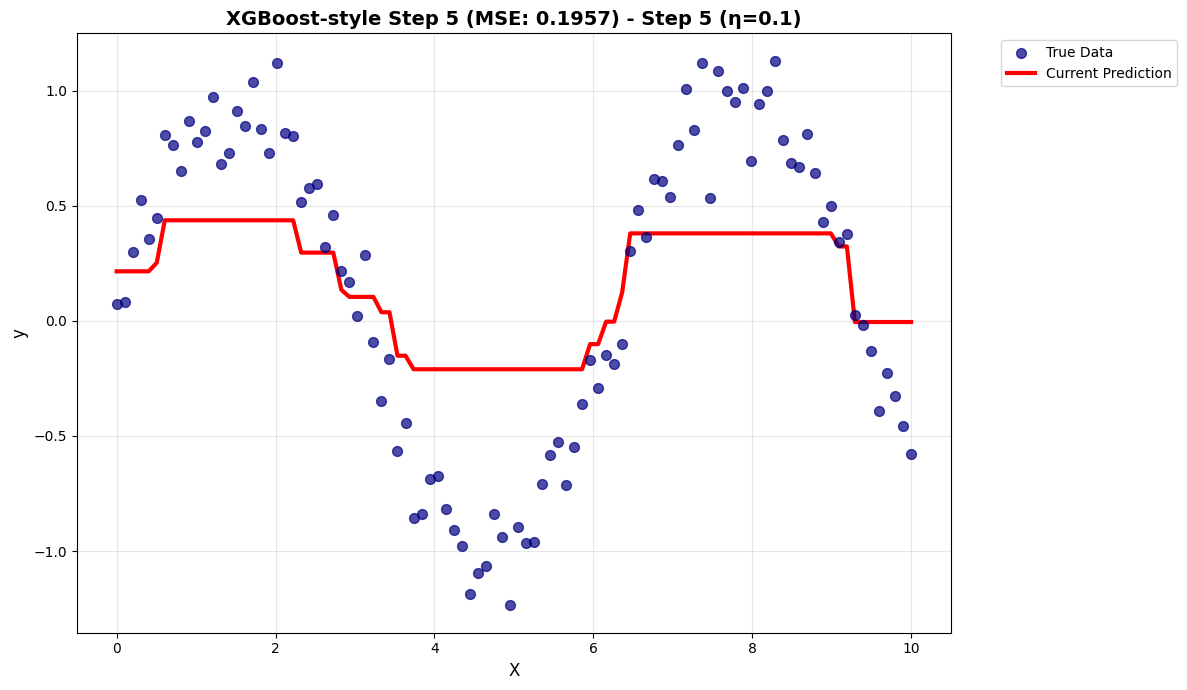

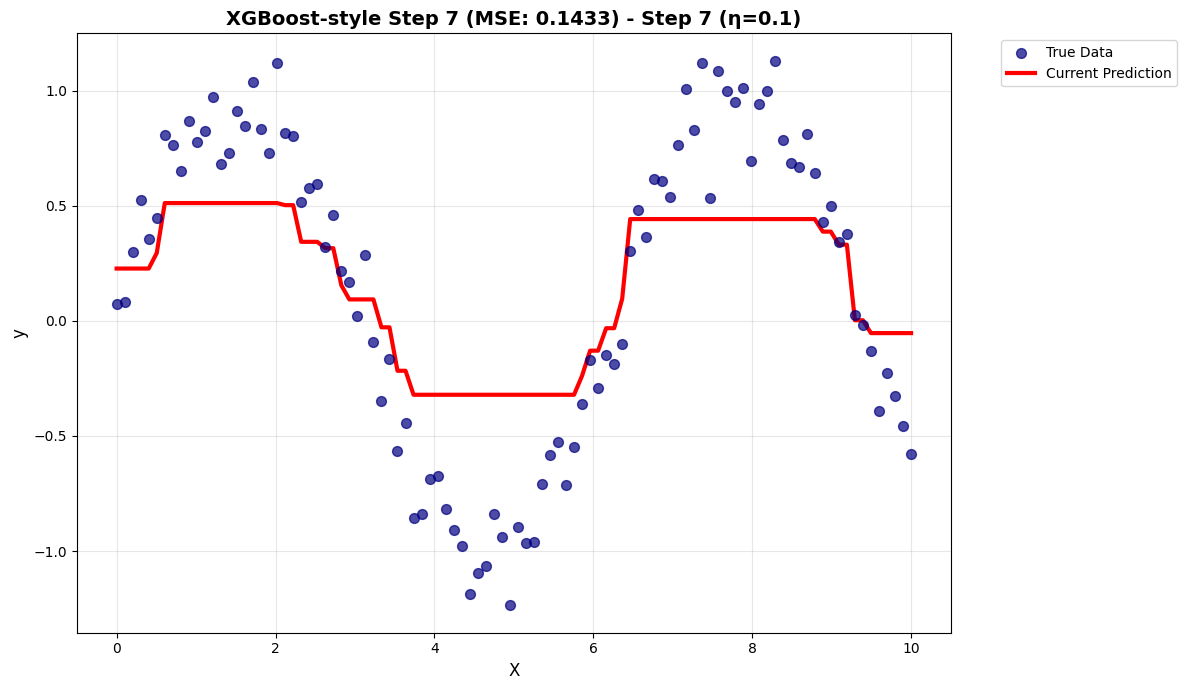

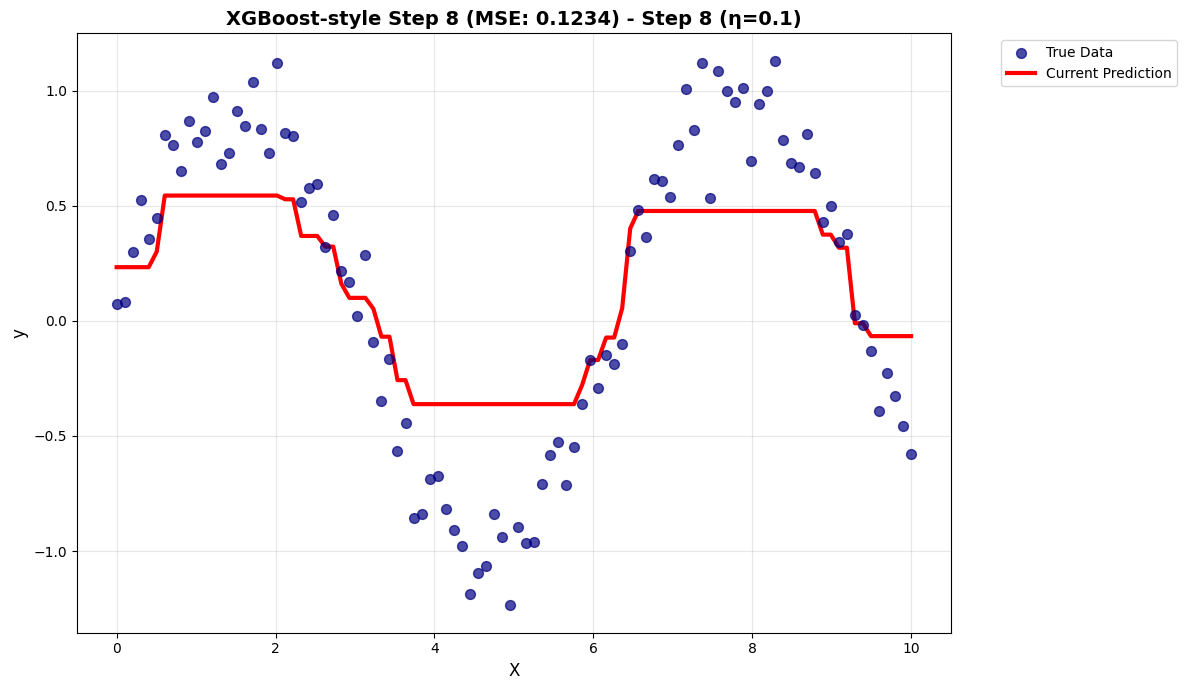

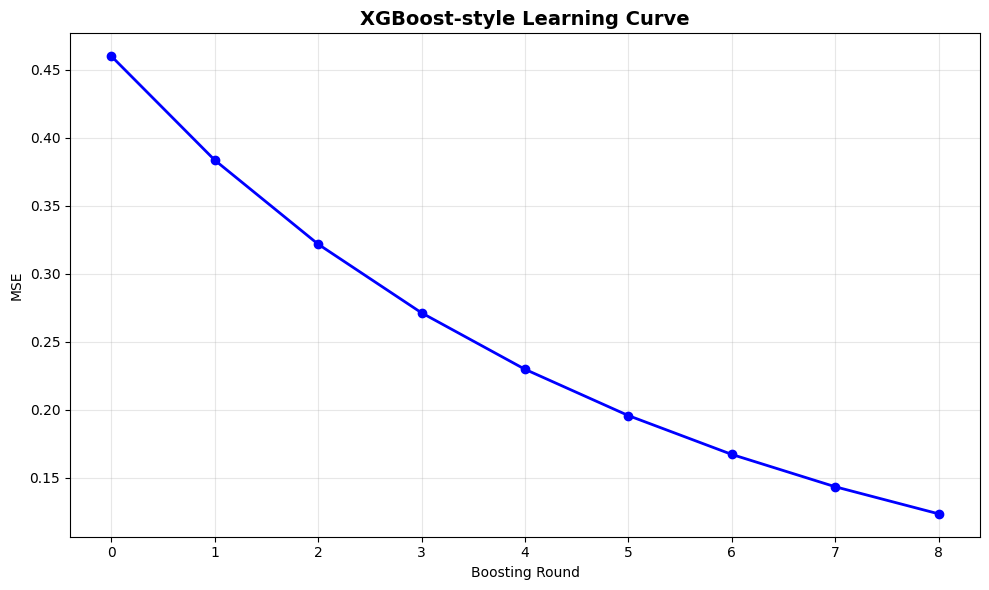


🎯 Final Comparison:
Manual XGBoost-style MSE: 0.1234
Sklearn Gradient Boosting MSE: 0.1222

4️⃣  COMPARISON OF ALL BOOSTING METHODS


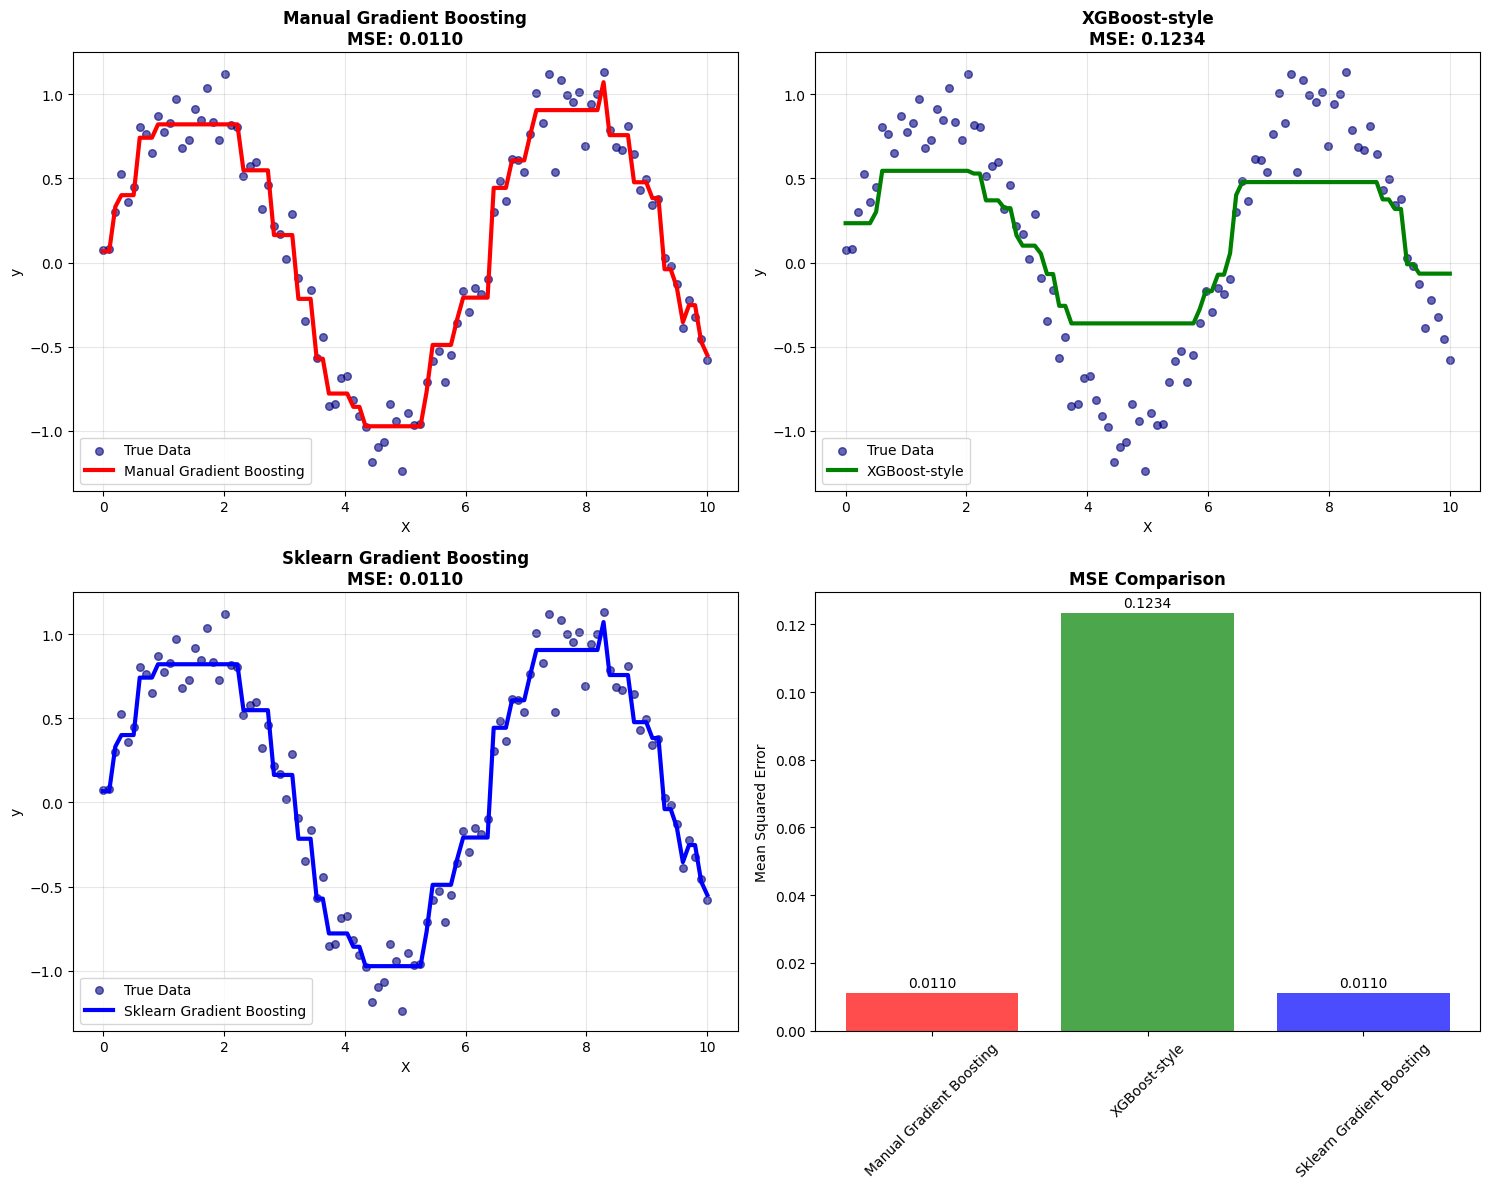


📊 PERFORMANCE SUMMARY:
--------------------------------------------------
Method                    | MSE      | Relative  
--------------------------------------------------
Manual Gradient Boosting  | 0.0110   | 1.00      x
Sklearn Gradient Boosting | 0.0110   | 1.00      x
XGBoost-style             | 0.1234   | 11.26     x


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.datasets import make_classification
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("🚀 BOOSTING ALGORITHMS TUTORIAL")
print("=" * 50)

# -----------------------------------------------------------------------------
# SETUP: Generate Data for Different Scenarios
# -----------------------------------------------------------------------------
np.random.seed(42)

# Regression data (sine wave with noise)
X_reg = np.linspace(0, 10, 100).reshape(-1, 1)
y_reg = np.sin(X_reg).flatten() + np.random.normal(scale=0.15, size=X_reg.flatten().shape)

# Classification data (2D with clear decision boundary)
X_class, y_class = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                     n_informative=2, n_clusters_per_class=1, 
                                     class_sep=0.8, random_state=42)

# Add some noise to make it more interesting
X_class += np.random.normal(0, 0.1, X_class.shape)

print("📊 Generated synthetic datasets:")
print(f"   - Regression: {X_reg.shape[0]} samples, sine wave with noise")
print(f"   - Classification: {X_class.shape[0]} samples, 2D binary problem")

# -----------------------------------------------------------------------------
# ENHANCED PLOTTING FUNCTIONS
# -----------------------------------------------------------------------------

def plot_regression_boosting(X, y, y_pred=None, residuals=None, title="", 
                           tree_idx=None, learning_rate=None, show_components=False,
                           component_preds=None):
    """Enhanced plotting for regression boosting"""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot true data
    ax.scatter(X.flatten(), y, color='navy', alpha=0.7, s=50, label="True Data", zorder=3)
    
    if y_pred is not None:
        ax.plot(X.flatten(), y_pred, color='red', linewidth=3, label='Current Prediction', zorder=2)
    
    if residuals is not None:
        # Show residuals as vertical lines
        for i in range(0, len(X), 3):  # Show every 3rd residual to avoid clutter
            ax.plot([X[i], X[i]], [y_pred[i], y[i]], color='orange', 
                   linestyle='--', alpha=0.7, linewidth=1)
        ax.scatter(X.flatten(), y, color='orange', s=20, alpha=0.8, 
                  label=f'Residuals (MAE: {np.mean(np.abs(residuals)):.3f})', zorder=3)
    
    # Show component predictions if available
    if show_components and component_preds is not None:
        colors = plt.cm.Set3(np.linspace(0, 1, len(component_preds)))
        for i, (comp_pred, color) in enumerate(zip(component_preds, colors)):
            ax.plot(X.flatten(), comp_pred, '--', color=color, alpha=0.6, 
                   linewidth=1.5, label=f'Tree {i+1}')
    
    if tree_idx is not None:
        title += f" - Step {tree_idx+1}"
        if learning_rate is not None and learning_rate != 1.0:
            title += f" (η={learning_rate})"
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_classification_boosting(X, y, classifier=None, title="", weights=None, 
                               misclassified=None, tree_idx=None):
    """Enhanced plotting for classification boosting"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create decision boundary if classifier provided
    if classifier is not None:
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        try:
            Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
        except:
            pass  # Skip if prediction fails
    
    # Plot points with size based on weights
    if weights is not None:
        sizes = 500 * weights / weights.max()  # Scale weights for visibility
    else:
        sizes = 50
    
    # Color points by class
    colors = ['lightblue' if label == 0 else 'lightcoral' for label in y]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=colors, s=sizes, 
                        alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Highlight misclassified points
    if misclassified is not None:
        ax.scatter(X[misclassified, 0], X[misclassified, 1], 
                  s=100, facecolors='none', edgecolors='red', 
                  linewidth=3, label='Misclassified')
    
    if tree_idx is not None:
        title += f" - Step {tree_idx+1}"
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    if misclassified is not None:
        ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 1. GRADIENT BOOSTING FOR REGRESSION (Your Original Example Enhanced)
# -----------------------------------------------------------------------------

print("\n" + "="*60)
print("1️⃣  GRADIENT BOOSTING FOR REGRESSION")
print("="*60)
print("""
🎯 CONCEPT: Sequentially fit weak learners to residuals
   • Start with simple prediction (mean)
   • At each step, fit a tree to predict the residuals
   • Add the new prediction to ensemble
   • Repeat until convergence or max iterations
""")

def gradient_boosting_regression_demo():
    # Initialize
    y_pred = np.full_like(y_reg, y_reg.mean())
    plot_regression_boosting(X_reg, y_reg, y_pred, title="Initial Prediction (Mean)")
    
    # Boosting parameters
    n_trees = 5
    max_depth = 3
    learning_rate = 0.8
    
    trees = []
    all_predictions = [y_pred.copy()]
    
    print(f"Parameters: n_trees={n_trees}, max_depth={max_depth}, learning_rate={learning_rate}")
    
    for i in range(n_trees):
        # Calculate residuals
        residuals = y_reg - y_pred
        
        print(f"\nStep {i+1}:")
        print(f"  Residual MSE: {np.mean(residuals**2):.4f}")
        print(f"  Residual MAE: {np.mean(np.abs(residuals)):.4f}")
        
        # Fit tree to residuals
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42+i)
        tree.fit(X_reg, residuals)
        
        # Make prediction
        tree_prediction = tree.predict(X_reg)
        
        # Show current state
        plot_regression_boosting(X_reg, y_reg, y_pred, residuals=residuals,
                               title="Fitting Tree to Residuals", tree_idx=i,
                               learning_rate=learning_rate)
        
        # Update ensemble prediction
        y_pred += learning_rate * tree_prediction
        all_predictions.append(y_pred.copy())
        trees.append(tree)
        
        # Show updated prediction
        plot_regression_boosting(X_reg, y_reg, y_pred, 
                               title="Updated Ensemble Prediction", 
                               tree_idx=i, learning_rate=learning_rate)
    
    # Final comparison with all components
    component_predictions = []
    cumulative_pred = np.full_like(y_reg, y_reg.mean())
    
    for i, tree in enumerate(trees):
        if i == 0:
            residuals = y_reg - cumulative_pred
        else:
            residuals = y_reg - cumulative_pred
        
        tree_pred = learning_rate * tree.predict(X_reg)
        component_predictions.append(cumulative_pred + tree_pred)
        cumulative_pred += tree_pred
    
    plot_regression_boosting(X_reg, y_reg, y_pred, 
                           title="Final Gradient Boosting Result - All Components",
                           show_components=True, component_preds=component_predictions)
    
    final_mse = np.mean((y_reg - y_pred)**2)
    print(f"\n🎯 Final MSE: {final_mse:.4f}")
    return trees, y_pred

gb_trees, gb_prediction = gradient_boosting_regression_demo()

# -----------------------------------------------------------------------------
# 2. ADABOOST FOR CLASSIFICATION
# -----------------------------------------------------------------------------

print("\n" + "="*60)
print("2️⃣  ADABOOST FOR CLASSIFICATION")
print("="*60)
print("""
🎯 CONCEPT: Adaptive Boosting - focus on misclassified examples
   • Start with equal weights for all samples
   • Train weak classifier on weighted data
   • Increase weights of misclassified examples  
   • Train next classifier on reweighted data
   • Combine classifiers with weighted voting
""")

def adaboost_demo():
    print("AdaBoost step-by-step demonstration:")
    
    # Initialize weights uniformly
    n_samples = len(X_class)
    weights = np.ones(n_samples) / n_samples
    
    n_estimators = 4
    classifiers = []
    classifier_weights = []
    
    # Show initial data
    plot_classification_boosting(X_class, y_class, title="Initial Data (Equal Weights)", 
                               weights=weights)
    
    for i in range(n_estimators):
        print(f"\n--- AdaBoost Step {i+1} ---")
        
        # Train weak classifier on weighted data
        clf = DecisionTreeClassifier(max_depth=1, random_state=42+i)
        
        # Fit with sample weights
        clf.fit(X_class, y_class, sample_weight=weights)
        
        # Make predictions
        y_pred = clf.predict(X_class)
        
        # Calculate error
        misclassified = (y_pred != y_class)
        error = np.average(misclassified, weights=weights)
        
        print(f"Weighted error: {error:.4f}")
        
        # Calculate classifier weight (alpha)
        if error == 0:
            alpha = 1.0
        elif error >= 0.5:
            alpha = 0.0
        else:
            alpha = 0.5 * np.log((1 - error) / error)
        
        print(f"Classifier weight (α): {alpha:.4f}")
        
        # Store classifier and its weight
        classifiers.append(clf)
        classifier_weights.append(alpha)
        
        # Show current classifier
        plot_classification_boosting(X_class, y_class, clf, 
                                   title=f"Weak Classifier {i+1} (α={alpha:.3f})",
                                   weights=weights, misclassified=misclassified,
                                   tree_idx=i)
        
        # Update sample weights
        weights *= np.exp(alpha * misclassified * (2 * (y_class == 0) - 1))
        weights /= weights.sum()  # Normalize
        
        print(f"Weight concentration: {weights.max()/weights.min():.2f}x")
        print(f"Misclassified samples: {misclassified.sum()}/{n_samples}")
    
    # Create final ensemble classifier
    class AdaBoostEnsemble:
        def __init__(self, classifiers, weights):
            self.classifiers = classifiers
            self.weights = weights
        
        def predict(self, X):
            predictions = np.array([clf.predict(X) for clf in self.classifiers])
            # Weighted voting
            weighted_predictions = np.zeros(len(X))
            for i, (pred, weight) in enumerate(zip(predictions, self.weights)):
                weighted_predictions += weight * (2 * pred - 1)  # Convert to -1,1
            return (weighted_predictions > 0).astype(int)
    
    ensemble = AdaBoostEnsemble(classifiers, classifier_weights)
    
    plot_classification_boosting(X_class, y_class, ensemble,
                               title="Final AdaBoost Ensemble",
                               weights=weights)
    
    # Compare with sklearn implementation
    sklearn_ada = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
    sklearn_ada.fit(X_class, y_class)
    
    manual_accuracy = np.mean(ensemble.predict(X_class) == y_class)
    sklearn_accuracy = sklearn_ada.score(X_class, y_class)
    
    print(f"\n🎯 Results:")
    print(f"Manual AdaBoost accuracy: {manual_accuracy:.3f}")
    print(f"Sklearn AdaBoost accuracy: {sklearn_accuracy:.3f}")
    
    return ensemble, weights

ada_ensemble, final_weights = adaboost_demo()

# -----------------------------------------------------------------------------
# 3. XGBOOST-STYLE BOOSTING (Regularized Gradient Boosting)
# -----------------------------------------------------------------------------

print("\n" + "="*60)
print("3️⃣  XGBOOST-STYLE REGULARIZED GRADIENT BOOSTING")
print("="*60)
print("""
🎯 CONCEPT: Gradient Boosting + Regularization + Advanced Optimization
   • Use second-order gradients (Hessian) for better optimization
   • Add L1/L2 regularization to prevent overfitting
   • Advanced tree construction algorithms
   • Built-in cross-validation and early stopping
""")

def xgboost_style_demo():
    """Simplified XGBoost-style algorithm demonstration"""
    
    # XGBoost-style parameters
    learning_rate = 0.1
    reg_lambda = 1.0  # L2 regularization
    reg_alpha = 0.0   # L1 regularization
    max_depth = 3
    n_estimators = 8
    
    print(f"XGBoost-style parameters:")
    print(f"  learning_rate: {learning_rate}")
    print(f"  reg_lambda (L2): {reg_lambda}")
    print(f"  max_depth: {max_depth}")
    print(f"  n_estimators: {n_estimators}")
    
    # Initialize with mean
    y_pred = np.full_like(y_reg, y_reg.mean())
    trees = []
    
    # Track metrics
    train_errors = [np.mean((y_reg - y_pred)**2)]
    
    for i in range(n_estimators):
        # Calculate gradients (first order)
        gradients = 2 * (y_pred - y_reg)  # derivative of MSE
        
        # Calculate hessians (second order) - for MSE, hessian is constant
        hessians = np.full_like(gradients, 2.0)
        
        # In real XGBoost, we would use gradients and hessians to optimize
        # leaf values, but here we'll use a simplified approach
        
        # Fit tree to negative gradients (like gradient boosting)
        tree = DecisionTreeRegressor(max_depth=max_depth, 
                                   min_samples_leaf=max(1, int(len(y_reg) * 0.05)),
                                   random_state=42+i)
        tree.fit(X_reg, -gradients)
        
        # Get tree predictions
        tree_pred = tree.predict(X_reg)
        
        # Apply regularization by shrinking the prediction
        # This is a simplified version of XGBoost's regularization
        regularization_factor = 1.0 / (1.0 + reg_lambda)
        tree_pred *= regularization_factor
        
        trees.append(tree)
        
        # Update prediction
        y_pred += learning_rate * tree_pred
        
        # Track error
        mse = np.mean((y_reg - y_pred)**2)
        train_errors.append(mse)
        
        if i % 2 == 0 or i == n_estimators - 1:  # Show every other step + last
            plot_regression_boosting(X_reg, y_reg, y_pred,
                                   title=f"XGBoost-style Step {i+1} (MSE: {mse:.4f})",
                                   tree_idx=i, learning_rate=learning_rate)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_errors)), train_errors, 'b-o', linewidth=2, markersize=6)
    plt.title("XGBoost-style Learning Curve", fontsize=14, fontweight='bold')
    plt.xlabel("Boosting Round")
    plt.ylabel("MSE")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare with sklearn GradientBoosting
    sklearn_gb = GradientBoostingRegressor(n_estimators=n_estimators, 
                                          learning_rate=learning_rate,
                                          max_depth=max_depth, 
                                          random_state=42)
    sklearn_gb.fit(X_reg, y_reg)
    sklearn_pred = sklearn_gb.predict(X_reg)
    
    manual_mse = np.mean((y_reg - y_pred)**2)
    sklearn_mse = np.mean((y_reg - sklearn_pred)**2)
    
    print(f"\n🎯 Final Comparison:")
    print(f"Manual XGBoost-style MSE: {manual_mse:.4f}")
    print(f"Sklearn Gradient Boosting MSE: {sklearn_mse:.4f}")
    
    return trees, y_pred, train_errors

xgb_trees, xgb_prediction, xgb_errors = xgboost_style_demo()

# -----------------------------------------------------------------------------
# 4. COMPARISON OF ALL METHODS
# -----------------------------------------------------------------------------

print("\n" + "="*60)
print("4️⃣  COMPARISON OF ALL BOOSTING METHODS")
print("="*60)

def compare_all_methods():
    """Compare all boosting methods side by side"""
    
    # Get predictions from sklearn implementations for fair comparison
    sklearn_gb = GradientBoostingRegressor(n_estimators=5, learning_rate=0.8, 
                                          max_depth=3, random_state=42)
    sklearn_gb.fit(X_reg, y_reg)
    sklearn_gb_pred = sklearn_gb.predict(X_reg)
    
    # Calculate MSE for all methods
    methods = {
        'Manual Gradient Boosting': gb_prediction,
        'XGBoost-style': xgb_prediction,
        'Sklearn Gradient Boosting': sklearn_gb_pred
    }
    
    mse_scores = {}
    for name, pred in methods.items():
        mse = np.mean((y_reg - pred)**2)
        mse_scores[name] = mse
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    colors = ['red', 'green', 'blue']
    
    for i, (name, pred) in enumerate(methods.items()):
        ax = axes[i]
        ax.scatter(X_reg.flatten(), y_reg, color='navy', alpha=0.6, s=30, label='True Data')
        ax.plot(X_reg.flatten(), pred, color=colors[i], linewidth=3, label=f'{name}')
        ax.set_title(f'{name}\nMSE: {mse_scores[name]:.4f}', fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('y')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # MSE comparison bar chart
    ax = axes[3]
    names = list(mse_scores.keys())
    scores = list(mse_scores.values())
    bars = ax.bar(names, scores, color=colors[:len(names)], alpha=0.7)
    ax.set_title('MSE Comparison', fontweight='bold')
    ax.set_ylabel('Mean Squared Error')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{score:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n📊 PERFORMANCE SUMMARY:")
    print("-" * 50)
    print(f"{'Method':<25} | {'MSE':<8} | {'Relative':<10}")
    print("-" * 50)
    
    best_mse = min(mse_scores.values())
    for name, mse in sorted(mse_scores.items(), key=lambda x: x[1]):
        relative = mse / best_mse
        print(f"{name:<25} | {mse:<8.4f} | {relative:<10.2f}x")

compare_all_methods()

# -----------------------------------------------------------------------------
# 5. KEY INSIGHTS AND TAKEAWAYS
# -----------------------------